# **Statistics analysis**

In [ ]:
# Libraries: Standard ones
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

# Library for boxplots
import seaborn as sns
import pandas as pd

# K-means function
!pip install kmodes
from sklearn.cluster import KMeans
from kmodes.kmodes import KModes
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.datasets import make_blobs

# Functions for silhouette
from sklearn.metrics import silhouette_samples, silhouette_score

# Function to standardize the data 
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
# Function to PCA
from sklearn.decomposition import PCA

# Functions for hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

from google.colab import files

# Style
sns.set_style('whitegrid')
plt.rc('figure', figsize=[8, 6])
pio.templates.default = "plotly_white"


In [ ]:
''' Important functions definitions '''
# Read data and clean/process it of different ways
def table_selector(df = None, opc = "read_data", **args):
  options = ["read_data", "games", "teams"]
  if opc == "read_data" or df is None: # Read the data
    try:
      df = pd.read_csv("footdata.csv")
    except:
      uploaded = files.upload()
      df = pd.read_csv("footdata.csv")
  if opc == "games":
    df = pd.get_dummies(df.drop(columns = ["Date"]), columns = ["FTR","HTR"])
  if opc == "teams":
    aux_dataH=df[['Date','HomeTeam','FTR'] + [x for x in data.columns if 'H' in x[::-1][:3]]].drop(columns='B365H')
    aux_dataH.columns=aux_dataH.columns.str.replace('H','')
    aux_dataA=df[['Date','HomeTeam','FTR','HTR'] + [x for x in data.columns if 'A' in x[::-1][:3]]].drop(columns='B365A')
    aux_dataA.columns=aux_dataA.columns.str.replace('H','').str.replace('A','')
    data_games=aux_dataH.append(aux_dataA.replace({'FTR':{'H':'A','A':'H'},'HTR':{'H':'A','A':'H'}}))
    df=data_games.rename(columns={'omeTeam':'Team'}).replace({'FTR':{'H':'W','A':'L'},'TR':{'H':'W','A':'L'}})
    df = pd.get_dummies(df, columns = ["FTR","TR"]).drop(columns='Date').groupby('Team').agg('sum') #sum of rows
  assert opc in options, "Error, option not valid. Choose {} options".format()
  return df

def plot_corr(df):
  corr = df.corr()
  # Generate a mask for the upper triangle
  mask = np.zeros_like(corr, dtype=np.bool)
  mask[np.triu_indices_from(mask, k=1)] = True

  # Generate a custom diverging colormap
  cmap = sns.diverging_palette(220, 10, as_cmap=True)
  sns.heatmap(corr, cmap=cmap, mask = mask)

# Compute silhouette_index for each range_n_clusters
def silhouette_index(df, range_n_clusters = range(2,17), **args):
  X = df.values
  for n in range_n_clusters:
    clusterer = KMeans(n_clusters=n, **args).fit(df) # Clustering with the given number of clusters
    cluster_labels = clusterer.labels_ # Extract the labels
    silhouette_avg = silhouette_score(X, cluster_labels) # Corresponding silhouette score
   
    # Display the results
    print("For n =", n, "Silhouette_score:", silhouette_avg)

# Compute clustering with MeanShift
def mean_shift(df):
  X = df.values
  # The following bandwidth can be automatically detected using
  bandwidth = estimate_bandwidth(df, quantile=0.2, n_samples=500)

  ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
  ms.fit(X)
  labels, cluster_centers  = ms.labels_, ms.cluster_centers_

  labels_unique = np.unique(labels)
  print(cluster_centers)
  n_clusters_ = len(labels_unique)

  print("number of estimated clusters : %d" % n_clusters_)
  silhouette_avg = silhouette_score(X, labels)
  print("Silhouette:",silhouette_avg )
  return ms

def hierarchical_clustering(df):
  # We standardize the columns of interest
  FOOT_scaled=pd.DataFrame(scale(df),columns=df.columns,index=df.index)
  print(FOOT_scaled)
  # We apply hierarchical clustering with dissimilarity measure "ward"
  Z = linkage(FOOT_scaled, 'ward') # 'average' is the method used to compute the distance. Metric is "euclidian" by default
  # We represent the corresponding Dendrogram
  plt.figure(figsize=(7, 7))
  plt.title('Hierarchical Clustering Dendrogram')
  plt.xlabel('sample index')
  plt.ylabel('distance')
  dendrogram(Z = linkage(FOOT_scaled, 'ward'))
  plt.show()
  return Z

def pca_process(df, columns_act, show = True):
  X = df[columns_act].values
  std_scale = StandardScaler().fit(X)
  X_scaled = std_scale.transform(X)
  pca = PCA().fit(X_scaled)
  X_proj = pca.transform(X_scaled)
  if show:
    fig = go.Figure(data=go.Scatter(x = ["comp_" + str(x+1) for x in range(pca.n_components_)],y = np.cumsum(pca.explained_variance_ratio_)))
    fig.update_layout(xaxis={'title':'Active components'}, yaxis={'title':'Cumsum PCA values'})
    fig.show()
  return X_proj, pca 

def components_analysis(df, columns_act, features):
  X_proj, pca = pca_process(df, columns_act, show = False)
  for var in range(pca.n_features_):
    _, axes = plt.subplots(ncols=len(features), figsize=(16,4))
    for i, (ax, col) in enumerate(zip(axes, features)):
        ax.scatter(X_proj[:,var], df[col])
        ax.set_title(f'{var+1}st component vs {col}')
  
def components3d_plot(df, X_proj, fulldata = False, names = None, **args):
  fact = 1.05
  data_comp = pd.DataFrame(X_proj[:,:3], columns=["comp1","comp2","comp3"])
  new_data = df.reset_index()
  total_data = data_comp.merge(new_data, left_index=True, right_index=True)
  limits = fact*(np.max(X_proj[:,:3], axis = 0) - np.min(X_proj[:,:3], axis = 0))
  limits = np.array([fact*np.min(X_proj[:,:3], axis = 0), limits + fact*np.min(X_proj[:,:3], axis = 0)])
  if fulldata: total_data = df.copy()
  if names is not None: 
    total_data["names"] = names
    fig = px.scatter_3d(total_data, x='comp1', y='comp2', z='comp3', hover_name="names",
                      range_x=list(limits[:,0]), range_y=list(limits[:,1]), range_z=list(limits[:,2]), **args)
  else:
    fig = px.scatter_3d(total_data, x='comp1', y='comp2', z='comp3',
                      range_x=list(limits[:,0]), range_y=list(limits[:,1]), range_z=list(limits[:,2]), **args)
  fig.show()
  return total_data

## Project description:

In this deliverable we will address the main characteristics of supervised learning methods that will be implemented to a data set of a total of 46012 videos from 58 french media channels and we will try to extract, clean and organize this information using mostly supervised learning algorithms.

The aim of this study is to understand and predict the notion of "toxicity" of a video. To do so, we first tackle this issue by solving a regression problem aiming to predict the total number of insults in the comments of a video. Then we build and predict a toxicity index by feature engineering.


The data contains the following information.

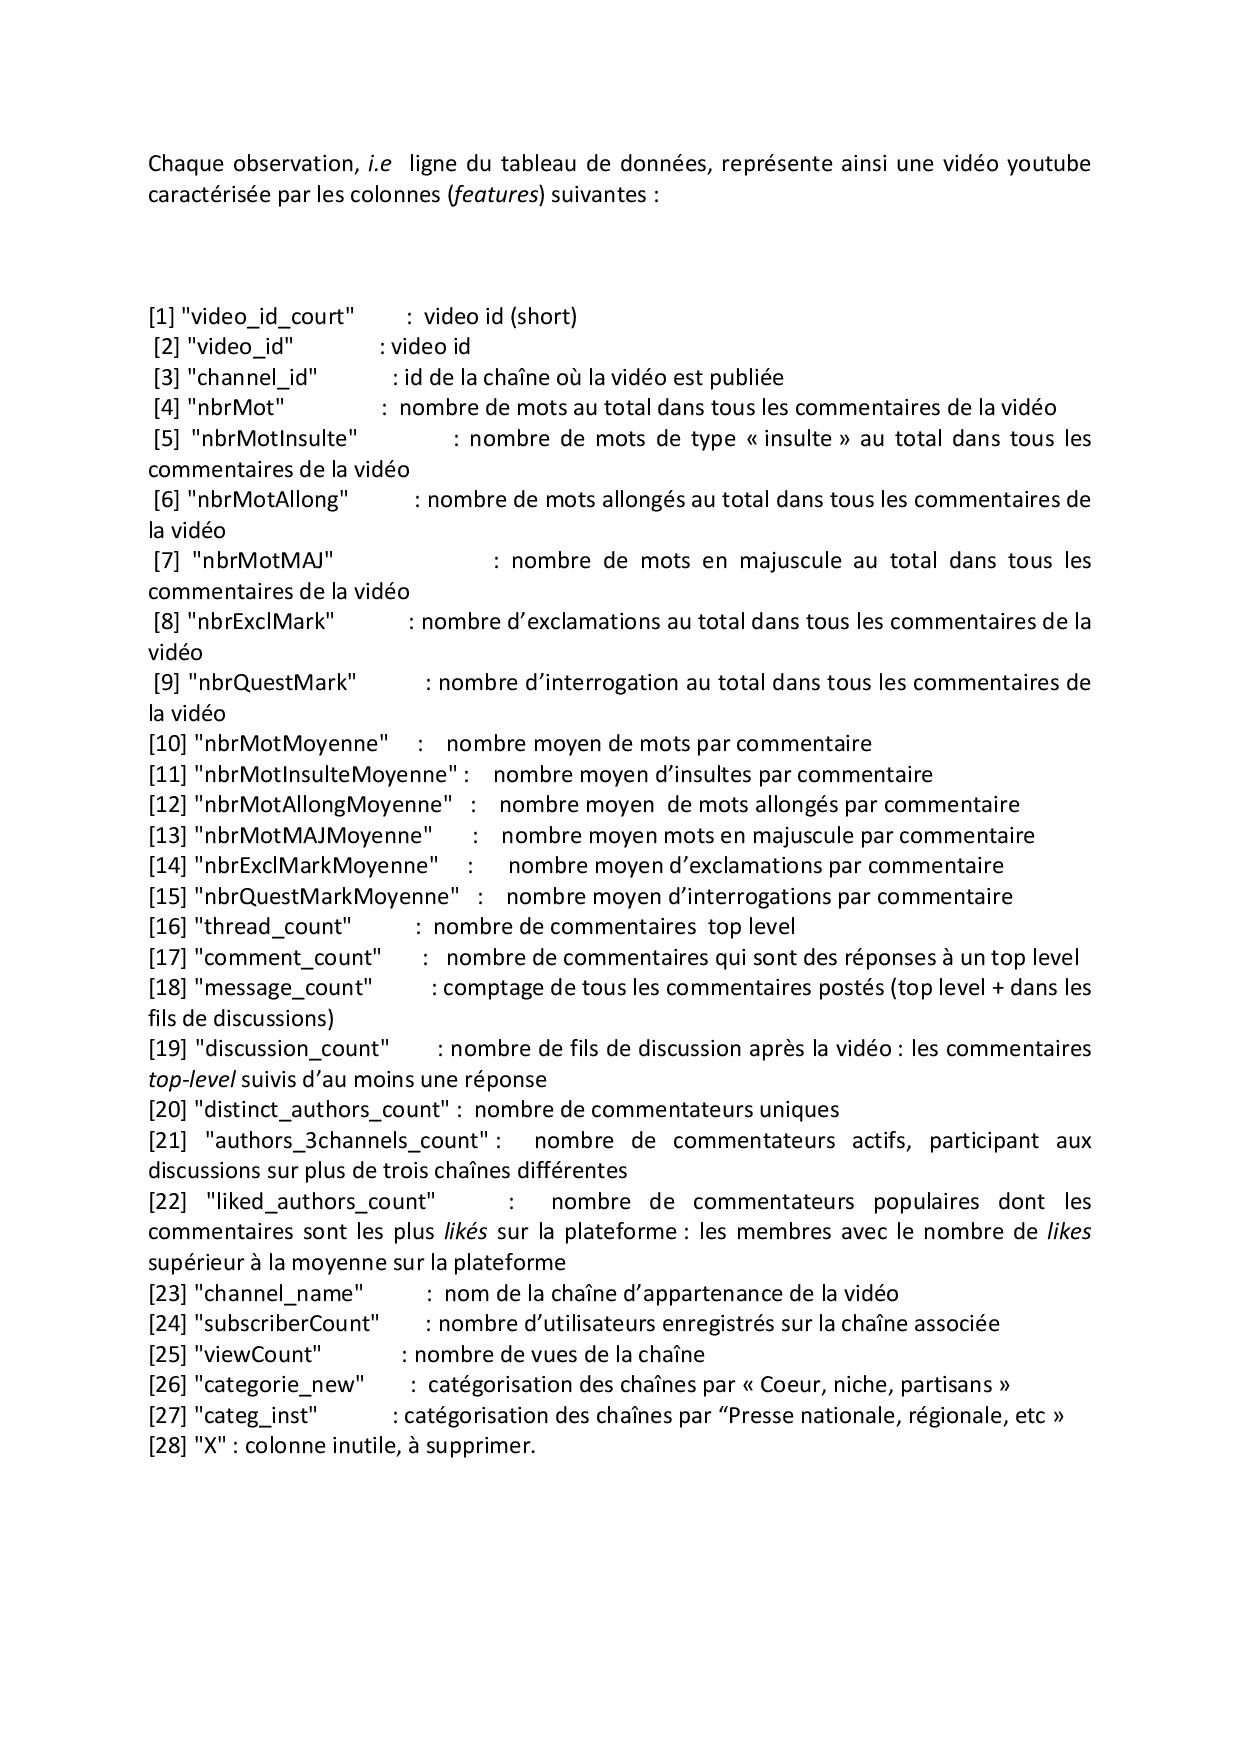

We try first to visualize our data and perform some exploratory statistics on it.

In [ ]:
df = pd.read_csv("challenge_youtube_toxic.csv", encoding = "ISO-8859-1", delimiter = ";", decimal=',').dropna(axis = 1)
df

,video_id_court,video_id,channel_id,nbrMot,nbrMotInsulte,nbrMotAllong,nbrMotMAJ,nbrExclMark,nbrQuestMark,nbrMotMoyenne,nbrMotInsulteMoyenne,nbrMotAllongMoyenne,nbrMotMAJMoyenne,nbrExclMarkMoyenne,nbrQuestMarkMoyenne,thread_count,comment_count,message_count,discussion_count,distinct_authors_count,authors_3channels_count,liked_authors_count,channel_name,subscriberCount,viewCount,categorie_new,categ_inst
0,Uvvsvw_wxOs,VVU5R0d6QWhodmhKTzFoTDEwLUJjZ05BLlV2dnN2d193eE9z,UC9GGzAhhvhJO1hL10-BcgNA,3813,18,4,145,79,60,30.261900,0.142857,0.031746,1.150794,0.626984,0.476190,45,81,126,28,58,47,23,LeHuffPost,339922,225393312,Core,Pure Players
1,mCy1ZBdttwA,VVVYS0pyWWN6WTJfZkpFWmdGUEdZMEhRLm1DeTFaQmR0dHdB,UCXKJrYczY2_fJEZgFPGY0HQ,28,2,0,1,0,0,9.333333,0.666667,0.000000,0.333333,0.000000,0.000000,3,0,3,0,3,1,0,CNEWS,189971,132125693,Core,TV
2,iU3MyHMK5nU,VVU5R0d6QWhodmhKTzFoTDEwLUJjZ05BLmlVM015SE1LNW5V,UC9GGzAhhvhJO1hL10-BcgNA,3804,68,9,56,75,54,27.565220,0.492754,0.065217,0.405797,0.543478,0.391304,52,86,138,22,83,49,36,LeHuffPost,339922,225393312,Core,Pure Players
3,ZUim3AeURtk,VVViWjBDc3I5b3c2WGprZGQ1NDJPbWh3LlpVaW0zQWVVUnRr,UCbZ0Csr9ow6Xjkdd542Omhw,4,0,1,2,0,0,2.000000,0.000000,0.500000,1.000000,0.000000,0.000000,2,0,2,0,2,0,0,Telegramme,2862,2481100,Niche,Presse_regionale
4,n5Tg2vhLCAM,VVVoWldzNlBKWTBoTkQzODRkMl9ScmhRLm41VGcydmhMQ0FN,UChZWs6PJY0hND384d2_RrhQ,737,3,1,18,5,6,32.043478,0.130435,0.043478,0.782609,0.217391,0.260870,17,6,23,4,18,7,7,Les Echos,30010,6710737,Core,Presse nationale
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46097,0s_hwJrt_6E,VVVmSG5fOC1laGRlbTg2ZkV2bEZnLUd3LjBzX2h3SnJ0XzZF,UCfHn_8-ehdem86fEvlFg-Gw,16,0,0,0,3,0,5.333333,0.000000,0.000000,0.000000,1.000000,0.000000,3,0,3,0,3,1,0,Le Parisien,149018,85536183,Core,Presse_regionale
46098,ktsFSiFN1VY,VVVZcFJEbmhrNUg4aDE2anBTODR1cXNBLmt0c0ZTaUZOMVZZ,UCYpRDnhk5H8h16jpS84uqsA,228,1,1,0,0,1,228.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1,0,1,0,1,0,0,Le Monde,568615,134570352,Core,Presse nationale
46099,-Zl5CiKdfAs,VVVYS0pyWWN6WTJfZkpFWmdGUEdZMEhRLi1abDVDaUtkZkFz,UCXKJrYczY2_fJEZgFPGY0HQ,287,2,0,3,2,0,35.875000,0.250000,0.000000,0.375000,0.250000,0.000000,8,0,8,0,7,5,3,CNEWS,189971,132125693,Core,TV
46100,CyHXcpFlrTg,VVVDRHpfWFllS1dkME9JeWpwOTVkcXlRLkN5SFhjcEZsclRn,UCCDz_XYeKWd0OIyjp95dqyQ,176,0,0,0,6,3,58.666670,0.000000,0.000000,0.000000,2.000000,1.000000,2,1,3,1,3,0,1,Le Figaro,180173,140135417,Core,Presse nationale


In [ ]:
display(df.info())
df_per_channel_id= df.groupby(by=['channel_id']).size().count()
df_per_channel_id

#58 different channel_id.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46102 entries, 0 to 46101
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   video_id_court           46102 non-null  object 
 1   video_id                 46102 non-null  object 
 2   channel_id               46102 non-null  object 
 3   nbrMot                   46102 non-null  int64  
 4   nbrMotInsulte            46102 non-null  int64  
 5   nbrMotAllong             46102 non-null  int64  
 6   nbrMotMAJ                46102 non-null  int64  
 7   nbrExclMark              46102 non-null  int64  
 8   nbrQuestMark             46102 non-null  int64  
 9   nbrMotMoyenne            46102 non-null  float64
 10  nbrMotInsulteMoyenne     46102 non-null  float64
 11  nbrMotAllongMoyenne      46102 non-null  float64
 12  nbrMotMAJMoyenne         46102 non-null  float64
 13  nbrExclMarkMoyenne       46102 non-null  float64
 14  nbrQuestMarkMoyenne   

None

58

In [ ]:
df_per_channel= df.groupby(by=['channel_name']).size().count()
df_per_channel
# 58 different channel names, thus each channel has its own id and not videos of the same media channel but on different youtube channels.

58

In [ ]:
# Remove useless column X and other columns that don't matter like video id and channel id
#var_that_dont_matter = ["video_id_court", "video_id", "channel_id","Unnamed: 27"]
var_that_dont_matter = ["video_id_court", "video_id", "channel_id"]
data = df.drop(columns = var_that_dont_matter )
data

,nbrMot,nbrMotInsulte,nbrMotAllong,nbrMotMAJ,nbrExclMark,nbrQuestMark,nbrMotMoyenne,nbrMotInsulteMoyenne,nbrMotAllongMoyenne,nbrMotMAJMoyenne,nbrExclMarkMoyenne,nbrQuestMarkMoyenne,thread_count,comment_count,message_count,discussion_count,distinct_authors_count,authors_3channels_count,liked_authors_count,channel_name,subscriberCount,viewCount,categorie_new,categ_inst
0,3813,18,4,145,79,60,30.261900,0.142857,0.031746,1.150794,0.626984,0.476190,45,81,126,28,58,47,23,LeHuffPost,339922,225393312,Core,Pure Players
1,28,2,0,1,0,0,9.333333,0.666667,0.000000,0.333333,0.000000,0.000000,3,0,3,0,3,1,0,CNEWS,189971,132125693,Core,TV
2,3804,68,9,56,75,54,27.565220,0.492754,0.065217,0.405797,0.543478,0.391304,52,86,138,22,83,49,36,LeHuffPost,339922,225393312,Core,Pure Players
3,4,0,1,2,0,0,2.000000,0.000000,0.500000,1.000000,0.000000,0.000000,2,0,2,0,2,0,0,Telegramme,2862,2481100,Niche,Presse_regionale
4,737,3,1,18,5,6,32.043478,0.130435,0.043478,0.782609,0.217391,0.260870,17,6,23,4,18,7,7,Les Echos,30010,6710737,Core,Presse nationale
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46097,16,0,0,0,3,0,5.333333,0.000000,0.000000,0.000000,1.000000,0.000000,3,0,3,0,3,1,0,Le Parisien,149018,85536183,Core,Presse_regionale
46098,228,1,1,0,0,1,228.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1,0,1,0,1,0,0,Le Monde,568615,134570352,Core,Presse nationale
46099,287,2,0,3,2,0,35.875000,0.250000,0.000000,0.375000,0.250000,0.000000,8,0,8,0,7,5,3,CNEWS,189971,132125693,Core,TV
46100,176,0,0,0,6,3,58.666670,0.000000,0.000000,0.000000,2.000000,1.000000,2,1,3,1,3,0,1,Le Figaro,180173,140135417,Core,Presse nationale


In [ ]:
display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46102 entries, 0 to 46101
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   nbrMot                   46102 non-null  int64  
 1   nbrMotInsulte            46102 non-null  int64  
 2   nbrMotAllong             46102 non-null  int64  
 3   nbrMotMAJ                46102 non-null  int64  
 4   nbrExclMark              46102 non-null  int64  
 5   nbrQuestMark             46102 non-null  int64  
 6   nbrMotMoyenne            46102 non-null  float64
 7   nbrMotInsulteMoyenne     46102 non-null  float64
 8   nbrMotAllongMoyenne      46102 non-null  float64
 9   nbrMotMAJMoyenne         46102 non-null  float64
 10  nbrExclMarkMoyenne       46102 non-null  float64
 11  nbrQuestMarkMoyenne      46102 non-null  float64
 12  thread_count             46102 non-null  int64  
 13  comment_count            46102 non-null  int64  
 14  message_count         

None

In [ ]:
# Stats: 
display(data.describe())
display(data.describe(include=['object']))

,nbrMot,nbrMotInsulte,nbrMotAllong,nbrMotMAJ,nbrExclMark,nbrQuestMark,nbrMotMoyenne,nbrMotInsulteMoyenne,nbrMotAllongMoyenne,nbrMotMAJMoyenne,nbrExclMarkMoyenne,nbrQuestMarkMoyenne,thread_count,comment_count,message_count,discussion_count,distinct_authors_count,authors_3channels_count,liked_authors_count,subscriberCount,viewCount
count,46102.000000,46102.000000,46102.000000,46102.000000,46102.000000,46102.000000,46102.000000,46102.000000,46102.000000,46102.000000,46102.000000,46102.000000,46102.000000,46102.000000,46102.000000,46102.000000,46102.000000,46102.000000,46102.000000,46102.000000,4.610200e+04
mean,1435.853564,9.418225,3.974665,21.922823,21.823066,13.591276,25.264768,0.189175,0.080849,0.583485,0.633837,0.276134,22.219145,25.700816,47.919960,5.040085,28.726021,14.502646,10.974036,172108.752744,9.255061e+07
std,7670.789422,61.616732,21.367879,130.038591,120.607203,68.803038,31.979351,0.444356,0.305948,3.114312,1.600474,0.950349,117.441322,130.742237,234.791106,19.578795,140.334032,56.251117,50.607716,119508.318824,6.778302e+07
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3.109100e+04
25%,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.769231,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,87793.000000,4.635634e+07
50%,72.000000,0.000000,0.000000,0.000000,1.000000,1.000000,18.630032,0.000000,0.000000,0.000000,0.250000,0.040161,3.000000,0.000000,4.000000,0.000000,3.000000,2.000000,1.000000,180173.000000,6.388093e+07
75%,398.000000,3.000000,1.000000,6.000000,9.000000,4.000000,31.000000,0.222222,0.068821,0.400000,0.750000,0.333333,9.000000,5.000000,16.000000,2.000000,11.000000,7.000000,4.000000,217835.000000,1.321257e+08
max,662808.000000,7227.000000,1416.000000,14270.000000,11093.000000,5520.000000,1349.500000,14.000000,28.000000,162.000000,104.000000,120.750000,8734.000000,11195.000000,19336.000000,1235.000000,9837.000000,3762.000000,3732.000000,568615.000000,2.414350e+08


,channel_name,categorie_new,categ_inst
count,46102,46102,46102
unique,58,3,6
top,CNEWS,Core,Presse nationale
freq,8950,38101,14244


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 131 missing from current font.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 131 missing from current font.



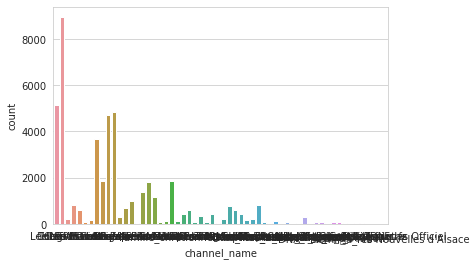

In [ ]:
sns.countplot(x='channel_name',data=data)

In [ ]:
data_per_channel= data.groupby(by=['channel_name']).size()
data_per_channel


channel_name
20MinutesFR                               588
Acrimed                                    55
AgoraVoxFrance                            179
Alternatives Economiques Officiel          31
AtlanticoFr                                 1
CNEWS                                    8950
Causeur                                    86
Contre Info                                23
Corse Net Infos                           111
Corse-Matin Presse                        107
Courrier international                     81
DNA - DerniÌå_res Nouvelles d'Alsace      10
Dauphine_libere                           219
Fakirpresse                                77
Famille_chretienne                        132
Fdesouche                                   7
France Net Infos journal                   27
France-Soir                               432
Gala                                      170
Humanite                                  799
L'Express                                 819
LCI                  

The five channels that submitted the greatest number of videos are by decreasing order: CNEWS, LeHuffPost, L'équipe, Le Figaro and franceinfo.

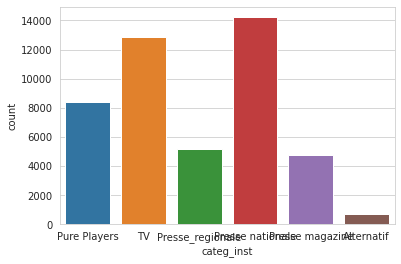

In [ ]:
sns.countplot(x='categ_inst',data=data)

In [ ]:
data_per_categ_inst= data.groupby(by=['categ_inst']).size()
data_per_categ_inst

categ_inst
Alternatif            711
Presse magazine      4756
Presse nationale    14244
Presse_regionale     5166
Pure Players         8394
TV                  12831
dtype: int64

 National Press and TV represent 57.75 % of the videos submitted. Pure players are the third of the ranking representing only 18.2 % of the submitted videos. Alternative is minoritary with only 1.5 % of the videos. The rest is almost equally shared between regional press and national and press magazine.

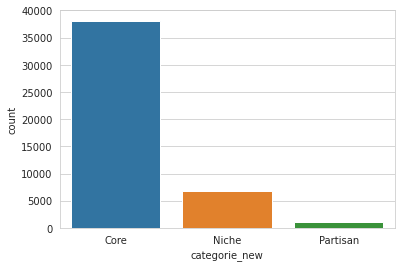

In [ ]:
sns.countplot(x='categorie_new',data=data)

Of course, core medias are by far the majoritary source of videos, followed by niche medias. The partisan here are minoritary, posting only 2.4 % of the total videos in the dataset.

In [ ]:
data_per_category= data.groupby(by=['categorie_new']).size()
data_per_category

categorie_new
Core        38101
Niche        6873
Partisan     1128
dtype: int64

In [ ]:
data_channel_2=df.groupby(by=['channel_name'])
data_channel_2

In [ ]:
def plot_corr(corr):
    # https://seaborn.pydata.org/examples/many_pairwise_correlations.html
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask,k=1)] = True
    
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    sns.heatmap(corr, mask=mask, cmap=cmap)

In [ ]:
#var_that_dont_matter = ["video_id_court", "video_id", "channel_id","Unnamed: 27", "channel_name", "categorie_new", "categ_inst"]
var_that_dont_matter = ["video_id_court", "video_id", "channel_id", "channel_name", "categorie_new", "categ_inst"]
data_quant = df.drop(columns = var_that_dont_matter )
data_quant


,nbrMot,nbrMotInsulte,nbrMotAllong,nbrMotMAJ,nbrExclMark,nbrQuestMark,nbrMotMoyenne,nbrMotInsulteMoyenne,nbrMotAllongMoyenne,nbrMotMAJMoyenne,nbrExclMarkMoyenne,nbrQuestMarkMoyenne,thread_count,comment_count,message_count,discussion_count,distinct_authors_count,authors_3channels_count,liked_authors_count,subscriberCount,viewCount
0,3813,18,4,145,79,60,30.261900,0.142857,0.031746,1.150794,0.626984,0.476190,45,81,126,28,58,47,23,339922,225393312
1,28,2,0,1,0,0,9.333333,0.666667,0.000000,0.333333,0.000000,0.000000,3,0,3,0,3,1,0,189971,132125693
2,3804,68,9,56,75,54,27.565220,0.492754,0.065217,0.405797,0.543478,0.391304,52,86,138,22,83,49,36,339922,225393312
3,4,0,1,2,0,0,2.000000,0.000000,0.500000,1.000000,0.000000,0.000000,2,0,2,0,2,0,0,2862,2481100
4,737,3,1,18,5,6,32.043478,0.130435,0.043478,0.782609,0.217391,0.260870,17,6,23,4,18,7,7,30010,6710737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46097,16,0,0,0,3,0,5.333333,0.000000,0.000000,0.000000,1.000000,0.000000,3,0,3,0,3,1,0,149018,85536183
46098,228,1,1,0,0,1,228.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1,0,1,0,1,0,0,568615,134570352
46099,287,2,0,3,2,0,35.875000,0.250000,0.000000,0.375000,0.250000,0.000000,8,0,8,0,7,5,3,189971,132125693
46100,176,0,0,0,6,3,58.666670,0.000000,0.000000,0.000000,2.000000,1.000000,2,1,3,1,3,0,1,180173,140135417


In [ ]:
corr = data_quant.corr()
corr

,nbrMot,nbrMotInsulte,nbrMotAllong,nbrMotMAJ,nbrExclMark,nbrQuestMark,nbrMotMoyenne,nbrMotInsulteMoyenne,nbrMotAllongMoyenne,nbrMotMAJMoyenne,nbrExclMarkMoyenne,nbrQuestMarkMoyenne,thread_count,comment_count,message_count,discussion_count,distinct_authors_count,authors_3channels_count,liked_authors_count,subscriberCount,viewCount
nbrMot,1.000000,0.871491,0.851083,0.843185,0.804115,0.972784,0.075012,0.014323,0.006139,-0.001154,-0.015492,0.012033,0.775471,0.924695,0.902798,0.868923,0.813164,0.851122,0.848354,0.158753,0.073630
nbrMotInsulte,0.871491,1.000000,0.766110,0.819455,0.763175,0.854249,0.041867,0.048479,0.004033,-0.000518,-0.009884,0.007036,0.718392,0.853120,0.834391,0.753119,0.750171,0.788718,0.778689,0.083189,0.057689
nbrMotAllong,0.851083,0.766110,1.000000,0.771871,0.811619,0.863186,0.044013,0.009013,0.046536,-0.001104,-0.016591,0.006716,0.851238,0.877789,0.914577,0.856128,0.886172,0.800444,0.872195,0.147688,0.087024
nbrMotMAJ,0.843185,0.819455,0.771871,1.000000,0.840114,0.847969,0.061648,0.021611,0.011895,0.072984,0.001784,0.012878,0.756191,0.810282,0.829444,0.761325,0.765811,0.749355,0.774137,0.108263,0.052209
nbrExclMark,0.804115,0.763175,0.811619,0.840114,1.000000,0.828670,0.043702,0.016170,0.005082,0.004082,0.025775,0.010112,0.923592,0.782705,0.897822,0.777075,0.895811,0.752613,0.837072,0.101257,0.073049
nbrQuestMark,0.972784,0.854249,0.863186,0.847969,0.828670,1.000000,0.064006,0.014444,0.006417,-0.001331,-0.012982,0.073284,0.794312,0.927122,0.913574,0.892087,0.826027,0.858038,0.855924,0.161235,0.083303
nbrMotMoyenne,0.075012,0.041867,0.044013,0.061648,0.043702,0.064006,1.000000,0.246022,0.191381,0.211840,0.189722,0.164161,0.022034,0.040467,0.033555,0.040151,0.022702,0.039169,0.027965,-0.002300,-0.020891
nbrMotInsulteMoyenne,0.014323,0.048479,0.009013,0.021611,0.016170,0.014444,0.246022,1.000000,0.029562,0.088727,0.111746,0.045457,0.003919,0.006060,0.005335,0.002530,0.001441,0.006877,0.001683,-0.001969,0.024727
nbrMotAllongMoyenne,0.006139,0.004033,0.046536,0.011895,0.005082,0.006417,0.191381,0.029562,1.000000,0.192410,0.087105,0.074788,0.002171,0.003152,0.002841,0.002141,0.002388,0.001259,0.002199,-0.024546,-0.024923
nbrMotMAJMoyenne,-0.001154,-0.000518,-0.001104,0.072984,0.004082,-0.001331,0.211840,0.088727,0.192410,1.000000,0.155056,0.066535,-0.005773,-0.007814,-0.007239,-0.009953,-0.008268,-0.008217,-0.009091,-0.027613,-0.018647


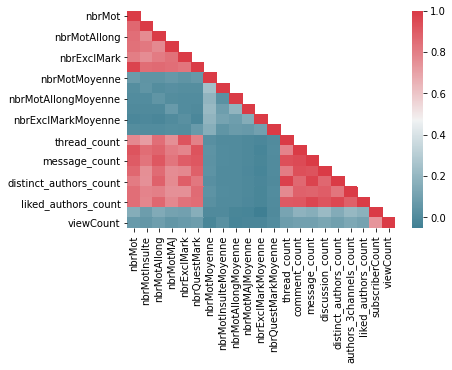

In [ ]:
plot_corr(corr)

 The variable nbrMot which is the total number of words in the comment of a video is unsuprisingly strongly significatively correlated with the total number of insults in the comments, the number of elongated words, the number of words in capital letters, the number of exclamation and question marks as well as the count of authors, threads, comments and discussions. The more words we have in total, the more likely there will be insults and any other words or signs of polemic or indignation. 

 NbrMotInsult, nbrMotAllong, nbrMotMAJ, nbrExclMark and nbrQuestMark are strongly significatively correlated with one another. This means that a video that gets negative reactions will get negative reactions of any type whether it is insults, anger that translates into capital letters words, mockery that translates into elongated words as well as many exclamations and interrogations.
 Those five variables are individualy strongly correlated with the number of authors in the channels and the discussion counts. The more polemic a video is the more debates there will be between comentators or even verbal jousting. 

 However, the means per commentary of those variables are almost uncorrelated. The eventual tones of a commentary seem to be independant of one another. 
 
 distinct_author_count is strongly correlated liked_authors_count. The more authors there are, the more authors who have likes more than average and lead the debate there will be.


 The viewCount is unsurprisingly strongly significatively correlated with the subscriberCount. However, viewCount is almost uncorrelated to nbrMot, nbMotMaj and nbrMotInsulte. We may expect that as the number of views grows, the more comments the video will get and the more insults words or any spelling that indicates some polemic the video will get. However, poeple's reactions especially negative ones are more driven by the content of the video. 

In [ ]:
ratio_columns = df.describe().columns
cat_columns = df.describe(include = 'O').columns
cat_columns


Index(['video_id_court', 'video_id', 'channel_id', 'channel_name',
       'categorie_new', 'categ_inst'],
      dtype='object')

In [ ]:
import plotly.graph_objects as go

data_channels=df.groupby(by=['channel_name']).mean().reset_index()
data_channels



,channel_name,nbrMot,nbrMotInsulte,nbrMotAllong,nbrMotMAJ,nbrExclMark,nbrQuestMark,nbrMotMoyenne,nbrMotInsulteMoyenne,nbrMotAllongMoyenne,nbrMotMAJMoyenne,nbrExclMarkMoyenne,nbrQuestMarkMoyenne,thread_count,comment_count,message_count,discussion_count,distinct_authors_count,authors_3channels_count,liked_authors_count,subscriberCount,viewCount
0,20MinutesFR,598.217687,5.935374,1.836735,11.615646,13.472789,7.284014,20.373181,0.155548,0.084704,0.502273,0.523425,0.353078,10.704082,12.035714,22.739796,2.534014,14.493197,6.420068,5.292517,16219.0,8683792.0
1,Acrimed,405.709091,2.981818,0.472727,3.490909,4.981818,3.145455,24.060274,0.129163,0.028816,0.351706,0.489666,0.282277,7.272727,3.072727,10.345455,1.254545,8.363636,5.709091,3.381818,5278.0,529390.0
2,AgoraVoxFrance,2635.357542,12.296089,18.374302,74.648045,135.983240,26.709497,18.133663,0.091186,0.056802,0.409553,0.714712,0.186400,183.821229,61.636872,245.458101,13.614525,197.703911,7.229050,59.715084,154937.0,241435040.0
3,Alternatives Economiques Officiel,205.903226,0.612903,0.387097,1.806452,4.290323,2.032258,33.522601,0.052970,0.093050,0.381517,0.696083,0.300347,4.161290,1.677419,5.838710,0.774194,4.548387,2.677419,1.516129,2724.0,199290.0
4,AtlanticoFr,5460.000000,97.000000,6.000000,198.000000,125.000000,54.000000,34.339620,0.610063,0.037736,1.245283,0.786164,0.339623,152.000000,7.000000,159.000000,5.000000,104.000000,43.000000,22.000000,74.0,261055.0
5,CNEWS,789.199441,7.219665,1.945363,16.293184,16.084022,8.358212,27.202790,0.299919,0.075035,0.711437,0.827864,0.362015,13.214413,11.078324,24.292737,2.726257,13.779553,8.155307,5.126369,189971.0,132125693.0
6,Causeur,718.093023,3.651163,1.186047,9.453488,9.569767,4.581395,44.599867,0.160446,0.080686,0.649699,0.594073,0.300204,7.034884,6.465116,13.500000,1.569767,7.604651,5.058140,2.581395,2619.0,937396.0
7,Contre Info,864.478261,7.130435,2.869565,15.347826,10.956522,8.608696,28.155413,0.282833,0.127988,0.668394,0.445731,0.389113,11.260870,10.782609,22.043478,3.043478,14.826087,7.043478,5.826087,202.0,207245.0
8,Corse Net Infos,342.846847,3.585586,0.621622,6.288288,4.333333,3.162162,23.108038,0.218989,0.029568,0.644651,0.659506,0.110983,2.513514,4.918919,7.432432,0.684685,3.108108,1.306306,0.666667,1124.0,741798.0
9,Corse-Matin Presse,67.074766,0.327103,0.467290,1.953271,1.766355,0.700935,15.814572,0.114703,0.111127,0.263514,0.464749,0.198856,2.504673,0.785047,3.289720,0.336449,2.775701,1.018692,0.644860,1363.0,1804396.0


In [ ]:
fig = go.Figure(data=[
    go.Bar(name='MeanInsultsWords', x = data_channels['channel_name'], y = data_channels['nbrMotInsulteMoyenne'],),
    go.Bar(name='MeanElongatedWords', x = data_channels['channel_name'], y = data_channels['nbrMotAllongMoyenne'],),
    go.Bar(name='MeanCapsWords', x = data_channels['channel_name'], y = data_channels['nbrMotMAJMoyenne'],),
    go.Bar(name='MeanExclamations', x = data_channels['channel_name'], y = data_channels['nbrExclMarkMoyenne'],),
    go.Bar(name='MeanInterrogation', x = data_channels['channel_name'], y = data_channels['nbrQuestMarkMoyenne'],)
  
])
fig.update_layout(barmode='group', yaxis={'title':'Mean per commentary'}, xaxis={'title':'Media channel'})
fig.show()

 For the mean number of insult words per commentary, the top 3 medias are AtlanticoFr, a core pure player media followed by Fdesouche and Lutte ouvrière which are both partisan media. For other medias, it is almost at the same level. Partisan medias are expected to have the highest means of insult words.
 For the mean number of elongated words per commentary, metronews seems to be an outlier, the other medias have a relatively high or average numbers while some medias have e very low level of elongated words such as ZDNet.fr which is a business and technology news site and 'La Voix du Nord'.
 For the mean number of capital letters words per commentary, there seem to be 3 ouliers above average, Libération, slate.fr which are core medias and fdsouche which is a partisan media. La manche, DNA and France Net Info have less than 1 capital letters words in ten commentaries. 
 For the mean number of exclamamtions per commentary, there seem to be only two ouliers that are below average DNA and ZDNet.fr.
 For the mean number of interrogations per commentary, la manche libre and orient XXI are significatively above average. Liberation and ZDNet are significatively below average. We expectt liberation to have an average mean number of interrogation per commentary as it is the case for other core medias.
 
  
 

## Analysis by Clustering and PCA techniques


  In order to understand the behaviour of videos as individuals, a new organisation of data is made which takes only into account the institutional categories as well as the general category of the media that posted it on Youtube.
  
  We used one hot encoding for both those categories: for the institutional category, we have the variables "categorie_new_Core",	"categorie_new_Niche","categorie_new_Partisan",	"categ_inst_Alternatif",	"categ_inst_Presse magazine" and	"categ_inst_Presse nationale". For the general category, we have added the variables "categ_inst_Presse_regionale",	"categ_inst_Pure Players",	 and "categ_inst_TV".
  In order to determine the toxicity of a video, we introduced the percentage of insults words, capital letters words and elogated words. These percentages allow us to visualise better the toxicity of a video since the length of the comments can vary widely from one comment to another.

In [ ]:
data_to_analyse = df.drop(columns = ["video_id_court", "video_id", "channel_id", "channel_name"])
ratio_columns = data_to_analyse.describe().columns
cat_columns = data_to_analyse.describe(include = 'O').columns
data_with_dummies = pd.get_dummies(data_to_analyse, columns = cat_columns)

data_with_dummies['percentage_insult_words'] = df.apply(lambda x: x['nbrMot'] if x['nbrMot'] == 0 else x['nbrMotInsulte']/x['nbrMot']*100, axis=1)
data_with_dummies['percentage_CAPS_words'] = df.apply(lambda x: x['nbrMot'] if x['nbrMot'] ==0 else x['nbrMotMAJ']/x['nbrMot']*100, axis=1)
data_with_dummies['percentage_elongated_words'] = df.apply(lambda x: x['nbrMot'] if x['nbrMot'] == 0 else x['nbrMotAllong']/x['nbrMot']*100, axis=1)

data_with_dummies


,nbrMot,nbrMotInsulte,nbrMotAllong,nbrMotMAJ,nbrExclMark,nbrQuestMark,nbrMotMoyenne,nbrMotInsulteMoyenne,nbrMotAllongMoyenne,nbrMotMAJMoyenne,nbrExclMarkMoyenne,nbrQuestMarkMoyenne,thread_count,comment_count,message_count,discussion_count,distinct_authors_count,authors_3channels_count,liked_authors_count,subscriberCount,viewCount,categorie_new_Core,categorie_new_Niche,categorie_new_Partisan,categ_inst_Alternatif,categ_inst_Presse magazine,categ_inst_Presse nationale,categ_inst_Presse_regionale,categ_inst_Pure Players,categ_inst_TV,percentage_insult_words,percentage_CAPS_words,percentage_elongated_words
0,3813,18,4,145,79,60,30.261900,0.142857,0.031746,1.150794,0.626984,0.476190,45,81,126,28,58,47,23,339922,225393312,1,0,0,0,0,0,0,1,0,0.472069,3.802780,0.104904
1,28,2,0,1,0,0,9.333333,0.666667,0.000000,0.333333,0.000000,0.000000,3,0,3,0,3,1,0,189971,132125693,1,0,0,0,0,0,0,0,1,7.142857,3.571429,0.000000
2,3804,68,9,56,75,54,27.565220,0.492754,0.065217,0.405797,0.543478,0.391304,52,86,138,22,83,49,36,339922,225393312,1,0,0,0,0,0,0,1,0,1.787592,1.472135,0.236593
3,4,0,1,2,0,0,2.000000,0.000000,0.500000,1.000000,0.000000,0.000000,2,0,2,0,2,0,0,2862,2481100,0,1,0,0,0,0,1,0,0,0.000000,50.000000,25.000000
4,737,3,1,18,5,6,32.043478,0.130435,0.043478,0.782609,0.217391,0.260870,17,6,23,4,18,7,7,30010,6710737,1,0,0,0,0,1,0,0,0,0.407056,2.442334,0.135685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46097,16,0,0,0,3,0,5.333333,0.000000,0.000000,0.000000,1.000000,0.000000,3,0,3,0,3,1,0,149018,85536183,1,0,0,0,0,0,1,0,0,0.000000,0.000000,0.000000
46098,228,1,1,0,0,1,228.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1,0,1,0,1,0,0,568615,134570352,1,0,0,0,0,1,0,0,0,0.438596,0.000000,0.438596
46099,287,2,0,3,2,0,35.875000,0.250000,0.000000,0.375000,0.250000,0.000000,8,0,8,0,7,5,3,189971,132125693,1,0,0,0,0,0,0,0,1,0.696864,1.045296,0.000000
46100,176,0,0,0,6,3,58.666670,0.000000,0.000000,0.000000,2.000000,1.000000,2,1,3,1,3,0,1,180173,140135417,1,0,0,0,0,1,0,0,0,0.000000,0.000000,0.000000


In order to identify the most efficient number of clusters for this data set using the K-means algorithm, the silhouette metric was used. The technique provides a representation that indicates how well each object has been classified. Tests were performed with a vector of 2-16 clusters and it can be observed that the silhouette score increases with n, however it is observed that the unsupervised learning method of K-means is not the most appropriate for this data set since no significant difference is observed when varying the number of clusters and it takes also a very high number of clusters.

In [ ]:
silhouette_index(data_with_dummies, n_init=40)

For n = 2 Silhouette_score: 0.7100290000601548
For n = 3 Silhouette_score: 0.7673462041646478
For n = 4 Silhouette_score: 0.8205658373959346
For n = 5 Silhouette_score: 0.8271382021981716
For n = 6 Silhouette_score: 0.8692729037962887
For n = 7 Silhouette_score: 0.84991898438038
For n = 8 Silhouette_score: 0.8542731991819374
For n = 9 Silhouette_score: 0.8710718861559347
For n = 10 Silhouette_score: 0.8678910375909606
For n = 11 Silhouette_score: 0.8691639352800986
For n = 12 Silhouette_score: 0.8790397530810511
For n = 13 Silhouette_score: 0.8864651201458331
For n = 14 Silhouette_score: 0.8916687086813639
For n = 15 Silhouette_score: 0.8971916182461381
For n = 16 Silhouette_score: 0.9250741654508098
For n = 17 Silhouette_score: 0.9444319934925425
For n = 18 Silhouette_score: 0.9403988427628756
For n = 19 Silhouette_score: 0.9456578024032151


 The silouhette score is increasing with the number of clusters, it seems that it is not appropriate to use k-means on this dataset.

In [ ]:
hierarchical_clustering(data_with_dummies)

         nbrMot  nbrMotInsulte  ...  categ_inst_Pure Players  categ_inst_TV
0      0.309899       0.139278  ...                 2.119494      -0.621008
1     -0.183536      -0.120394  ...                -0.471811       1.610285
2      0.308726       0.950755  ...                 2.119494      -0.621008
3     -0.186665      -0.152853  ...                -0.471811      -0.621008
4     -0.091107      -0.104165  ...                -0.471811      -0.621008
...         ...            ...  ...                      ...            ...
46097 -0.185101      -0.152853  ...                -0.471811      -0.621008
46098 -0.157463      -0.136624  ...                -0.471811      -0.621008
46099 -0.149772      -0.120394  ...                -0.471811       1.610285
46100 -0.164242      -0.152853  ...                -0.471811      -0.621008
46101  1.977933       2.314036  ...                 2.119494      -0.621008

[46102 rows x 30 columns]


## Mean shift

Another unsupervised learning algorithm called mean shift was performed, in this it is in charge of analyzing the 30 components that compose the data set, these are represented in 30 dimensions, this algorithm does not measure the points by distance, instead it makes use of a metric called bandwith selection that is a non-parametric way to estimate the probability density function of a random variable. By means of this metric the algorithm centers a circular window that encompasses all 30 dimensions of the components and that moves the nucleus in an iterative way to a region of higher density until convergence.

The algorithm indicates the coordinates of the components and classifies them within the nucleus using the metrics described above, it also indicates the optimal number of clusters is 4 and also the highest silhouette score was 0.8018013201173259, which as explained above is a technique that provides a representation that indicates how well each object has been classified.

In [ ]:
ms = mean_shift(data_with_dummies)
ms.labels_

[[1.04947247e+03 6.73779109e+00 2.43463114e+00 1.69138194e+01
  1.45987409e+01 9.19784854e+00 2.82291355e+01 1.79443690e-01
  9.40836820e-02 7.11711542e-01 7.02836979e-01 2.88037381e-01
  1.42749832e+01 1.33220463e+01 2.75970295e+01 2.72275533e+00
  1.70136300e+01 7.76077257e+00 6.21441232e+00 7.76434104e+04
  2.41452598e+07 8.18654116e-01 1.23342094e-01 5.80037895e-02
  4.34570014e-02 1.27314956e-01 2.00476743e-01 2.03655033e-01
  1.87885826e-01 2.37210439e-01 9.94346081e-01 2.69286234e+00
  8.33909173e-01]
 [1.46161843e+03 7.85184939e+00 3.68331230e+00 2.29193174e+01
  2.17216283e+01 1.41280297e+01 2.68458280e+01 2.35777234e-01
  7.35704889e-02 6.47699014e-01 7.45772934e-01 3.32264080e-01
  2.07521748e+01 2.48247560e+01 4.55769307e+01 5.02038648e+00
  2.62245169e+01 1.38859154e+01 1.01046550e+01 2.21721859e+05
  1.34863178e+08 1.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 4.05671027e-01 0.00000000e+00
  0.00000000e+00 5.94328973e-01 1.15034078e+00 2.486

array([3, 1, 3, ..., 1, 1, 3])

In [ ]:
cluster_indexes = ms.labels_
df_clust = pd.DataFrame(cluster_indexes,columns = ['cluster_indexes'])
df_clust


,cluster_indexes
0,3
1,1
2,3
3,0
4,0
...,...
46097,2
46098,1
46099,1
46100,1


In [ ]:
data_with_dummies
result = pd.concat([data_with_dummies, df_clust], axis=1, sort=False)
result.to_csv('data_with_cluster_indexes.csv')
result

,nbrMot,nbrMotInsulte,nbrMotAllong,nbrMotMAJ,nbrExclMark,nbrQuestMark,nbrMotMoyenne,nbrMotInsulteMoyenne,nbrMotAllongMoyenne,nbrMotMAJMoyenne,nbrExclMarkMoyenne,nbrQuestMarkMoyenne,thread_count,comment_count,message_count,discussion_count,distinct_authors_count,authors_3channels_count,liked_authors_count,subscriberCount,viewCount,categorie_new_Core,categorie_new_Niche,categorie_new_Partisan,categ_inst_Alternatif,categ_inst_Presse magazine,categ_inst_Presse nationale,categ_inst_Presse_regionale,categ_inst_Pure Players,categ_inst_TV,percentage_insult_words,percentage_CAPS_words,percentage_elongated_words,cluster_indexes
0,3813,18,4,145,79,60,30.261900,0.142857,0.031746,1.150794,0.626984,0.476190,45,81,126,28,58,47,23,339922,225393312,1,0,0,0,0,0,0,1,0,0.472069,3.802780,0.104904,3
1,28,2,0,1,0,0,9.333333,0.666667,0.000000,0.333333,0.000000,0.000000,3,0,3,0,3,1,0,189971,132125693,1,0,0,0,0,0,0,0,1,7.142857,3.571429,0.000000,1
2,3804,68,9,56,75,54,27.565220,0.492754,0.065217,0.405797,0.543478,0.391304,52,86,138,22,83,49,36,339922,225393312,1,0,0,0,0,0,0,1,0,1.787592,1.472135,0.236593,3
3,4,0,1,2,0,0,2.000000,0.000000,0.500000,1.000000,0.000000,0.000000,2,0,2,0,2,0,0,2862,2481100,0,1,0,0,0,0,1,0,0,0.000000,50.000000,25.000000,0
4,737,3,1,18,5,6,32.043478,0.130435,0.043478,0.782609,0.217391,0.260870,17,6,23,4,18,7,7,30010,6710737,1,0,0,0,0,1,0,0,0,0.407056,2.442334,0.135685,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46097,16,0,0,0,3,0,5.333333,0.000000,0.000000,0.000000,1.000000,0.000000,3,0,3,0,3,1,0,149018,85536183,1,0,0,0,0,0,1,0,0,0.000000,0.000000,0.000000,2
46098,228,1,1,0,0,1,228.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1,0,1,0,1,0,0,568615,134570352,1,0,0,0,0,1,0,0,0,0.438596,0.000000,0.438596,1
46099,287,2,0,3,2,0,35.875000,0.250000,0.000000,0.375000,0.250000,0.000000,8,0,8,0,7,5,3,189971,132125693,1,0,0,0,0,0,0,0,1,0.696864,1.045296,0.000000,1
46100,176,0,0,0,6,3,58.666670,0.000000,0.000000,0.000000,2.000000,1.000000,2,1,3,1,3,0,1,180173,140135417,1,0,0,0,0,1,0,0,0,0.000000,0.000000,0.000000,1


In [ ]:
result.groupby(by =['cluster_indexes']).mean()

,nbrMot,nbrMotInsulte,nbrMotAllong,nbrMotMAJ,nbrExclMark,nbrQuestMark,nbrMotMoyenne,nbrMotInsulteMoyenne,nbrMotAllongMoyenne,nbrMotMAJMoyenne,nbrExclMarkMoyenne,nbrQuestMarkMoyenne,thread_count,comment_count,message_count,discussion_count,distinct_authors_count,authors_3channels_count,liked_authors_count,subscriberCount,viewCount,categorie_new_Core,categorie_new_Niche,categorie_new_Partisan,categ_inst_Alternatif,categ_inst_Presse magazine,categ_inst_Presse nationale,categ_inst_Presse_regionale,categ_inst_Pure Players,categ_inst_TV,percentage_insult_words,percentage_CAPS_words,percentage_elongated_words
cluster_indexes,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,487.794778,4.418602,1.674890,9.424650,8.704070,4.593876,24.976627,0.154850,0.101216,0.646996,0.689559,0.260539,9.557593,8.195815,17.753408,1.736322,11.841236,5.058169,4.010175,20688.599539,1.088612e+07,0.715204,0.193703,0.091092,0.068247,0.199942,0.314840,0.319831,0.076982,0.020157,0.971512,2.703177,0.989542
1,1461.618434,7.851849,3.683312,22.919317,21.721628,14.128030,26.845828,0.235777,0.073570,0.647699,0.745773,0.332264,20.752175,24.824756,45.576931,5.020386,26.224517,13.885915,10.104655,221721.859154,1.348632e+08,1.000000,0.000000,0.000000,0.000000,0.000000,0.405671,0.000000,0.000000,0.594329,1.150341,2.486502,0.423128
2,1576.924338,10.601241,4.033910,24.395165,23.287096,14.387586,24.984838,0.176972,0.075582,0.549182,0.554902,0.245603,23.032800,26.088402,49.121202,5.121464,29.308331,14.361647,11.194250,170195.471219,6.014297e+07,0.682783,0.317217,0.000000,0.000000,0.174649,0.317217,0.119830,0.148448,0.239856,1.065791,2.227386,0.728606
3,2813.634586,20.239286,9.132519,36.464286,43.588910,27.400376,22.158940,0.159586,0.076719,0.376034,0.434951,0.235620,48.825564,61.345113,110.170677,11.331391,67.196617,35.148872,26.438534,333697.880639,2.259331e+08,0.966353,0.000000,0.033647,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.987754,1.844592,0.840062


  The cluster 0 has the highest percentage of capital letter words and elongated words with the less percentage of insult words. Those videos have thus a higher propensity for anger and shame with less insults than other clusters. The cluster 1 has the highest percentage of insult words with a high percentage of capital letters words and the lesser percentage of elongated words. The videos of the cluster 1 have a lesser propensity for shame while having a high propensity for anger and insults.
  The cluster 2 a high percentage of insult words and medium percentages of capital letters words and elongated words. Those videos have a high propensity to insults and a medium one to shame and anger. It is a cluster of medium toxicity.
  The cluster 3 has a high percentage of elongated words with low percentages of insults and capital letter words. Those videos has less propensity to insults and anger with a high propensity to shame. It is the less toxic cluster.

## Conclusion:

 The clusters 0 and 1 are almost at draw in terms of toxicity with a high toxicity while the cluster 2 is of intermediate toxicity and the cluster 3 the less toxic.

## PCA

PCA is a mathematical method used to reduce the number of variables so that we have the minimum number of components and represent all the variables that make up a data group in the most representative way possible. That is, if you reduce the number of variables to two or three new ones, you can represent the original data on the plane or on a 3-dimensional graph and, thus, a summary of our data is displayed graphically. The simple fact of having the data visible makes it much easier to understand what may be happening and to simplify the decision making process.

All components were compared in order to visualize the degree of correlation between each of them and to have an approach to what could be useful information for decision making.

In [ ]:
# Heatmap
corr = data_with_dummies.corr()
corr


,nbrMot,nbrMotInsulte,nbrMotAllong,nbrMotMAJ,nbrExclMark,nbrQuestMark,nbrMotMoyenne,nbrMotInsulteMoyenne,nbrMotAllongMoyenne,nbrMotMAJMoyenne,nbrExclMarkMoyenne,nbrQuestMarkMoyenne,thread_count,comment_count,message_count,discussion_count,distinct_authors_count,authors_3channels_count,liked_authors_count,subscriberCount,viewCount,categorie_new_Core,categorie_new_Niche,categorie_new_Partisan,categ_inst_Alternatif,categ_inst_Presse magazine,categ_inst_Presse nationale,categ_inst_Presse_regionale,categ_inst_Pure Players,categ_inst_TV,percentage_insult_words,percentage_CAPS_words,percentage_elongated_words
nbrMot,1.000000,0.871491,0.851083,0.843185,0.804115,0.972784,0.075012,0.014323,0.006139,-0.001154,-0.015492,0.012033,0.775471,0.924695,0.902798,0.868923,0.813164,0.851122,0.848354,0.158753,0.073630,0.057460,-0.056537,-0.010516,-0.013082,-0.021091,-0.009705,-0.006936,0.103186,-0.056051,-0.017741,-0.018309,-0.015865
nbrMotInsulte,0.871491,1.000000,0.766110,0.819455,0.763175,0.854249,0.041867,0.048479,0.004033,-0.000518,-0.009884,0.007036,0.718392,0.853120,0.834391,0.753119,0.750171,0.788718,0.778689,0.083189,0.057689,0.033912,-0.031533,-0.010435,-0.011551,-0.019772,-0.030609,0.009643,0.079655,-0.027221,0.002783,-0.011437,-0.012074
nbrMotAllong,0.851083,0.766110,1.000000,0.771871,0.811619,0.863186,0.044013,0.009013,0.046536,-0.001104,-0.016591,0.006716,0.851238,0.877789,0.914577,0.856128,0.886172,0.800444,0.872195,0.147688,0.087024,0.042842,-0.046015,0.001062,-0.013930,-0.020353,-0.008913,0.005184,0.095921,-0.059410,-0.014671,-0.014569,-0.002089
nbrMotMAJ,0.843185,0.819455,0.771871,1.000000,0.840114,0.847969,0.061648,0.021611,0.011895,0.072984,0.001784,0.012878,0.756191,0.810282,0.829444,0.761325,0.765811,0.749355,0.774137,0.108263,0.052209,0.046530,-0.049514,0.000086,-0.008013,-0.014435,-0.017871,0.000553,0.068417,-0.028876,-0.012616,0.042695,-0.013256
nbrExclMark,0.804115,0.763175,0.811619,0.840114,1.000000,0.828670,0.043702,0.016170,0.005082,0.004082,0.025775,0.010112,0.923592,0.782705,0.897822,0.777075,0.895811,0.752613,0.837072,0.101257,0.073049,0.046256,-0.054221,0.011609,-0.010582,-0.006455,-0.026549,0.001742,0.077200,-0.033038,-0.012858,-0.007142,-0.013303
nbrQuestMark,0.972784,0.854249,0.863186,0.847969,0.828670,1.000000,0.064006,0.014444,0.006417,-0.001331,-0.012982,0.073284,0.794312,0.927122,0.913574,0.892087,0.826027,0.858038,0.855924,0.161235,0.083303,0.061240,-0.060517,-0.010605,-0.014190,-0.020240,-0.013267,-0.004358,0.102250,-0.053660,-0.017320,-0.017003,-0.015902
nbrMotMoyenne,0.075012,0.041867,0.044013,0.061648,0.043702,0.064006,1.000000,0.246022,0.191381,0.211840,0.189722,0.164161,0.022034,0.040467,0.033555,0.040151,0.022702,0.039169,0.027965,-0.002300,-0.020891,0.099447,-0.116565,0.024948,0.022020,-0.007633,-0.032033,-0.065354,0.023106,0.058255,-0.057804,-0.006000,-0.060138
nbrMotInsulteMoyenne,0.014323,0.048479,0.009013,0.021611,0.016170,0.014444,0.246022,1.000000,0.029562,0.088727,0.111746,0.045457,0.003919,0.006060,0.005335,0.002530,0.001441,0.006877,0.001683,-0.001969,0.024727,0.030223,-0.026535,-0.012913,-0.010720,-0.044820,-0.060092,-0.022131,-0.027910,0.134931,0.482105,0.027250,-0.030182
nbrMotAllongMoyenne,0.006139,0.004033,0.046536,0.011895,0.005082,0.006417,0.191381,0.029562,1.000000,0.192410,0.087105,0.074788,0.002171,0.003152,0.002841,0.002141,0.002388,0.001259,0.002199,-0.024546,-0.024923,0.000836,-0.000561,-0.000756,0.002549,-0.003519,0.003029,0.012400,-0.006152,-0.004866,-0.015574,0.045277,0.335578
nbrMotMAJMoyenne,-0.001154,-0.000518,-0.001104,0.072984,0.004082,-0.001331,0.211840,0.088727,0.192410,1.000000,0.155056,0.066535,-0.005773,-0.007814,-0.007239,-0.009953,-0.008268,-0.008217,-0.009091,-0.027613,-0.018647,0.031879,-0.035681,0.004114,0.007276,-0.001509,-0.017011,-0.012046,-0.012286,0.035620,-0.004925,0.586411,-0.006203


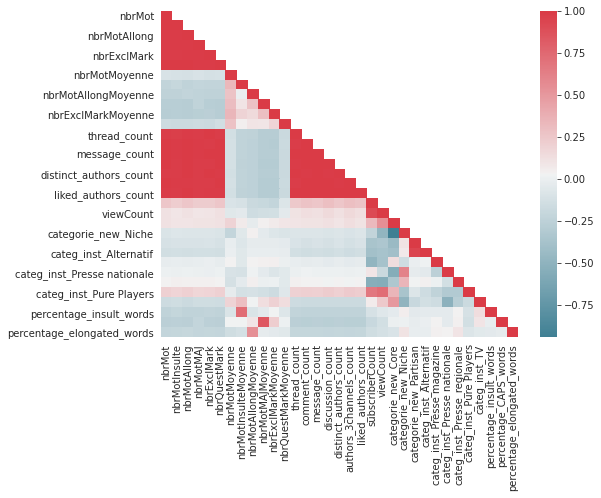

In [ ]:
plot_corr(corr)

The active variables here seem to be nbrMot, nbrMotInsult, nbrMotAllong, nbrMotMAJ	nbrExclMark	nbrQuestMark, thread_count,	comment_count,	message_count,	discussion_count,	distinct_authors_count,	authors_3channels_count and	liked_authors_count.

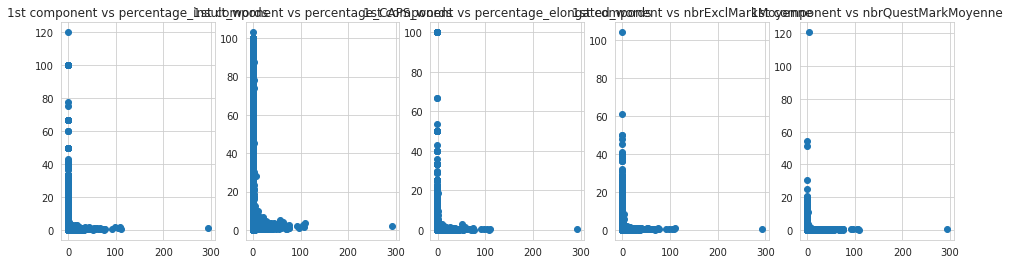

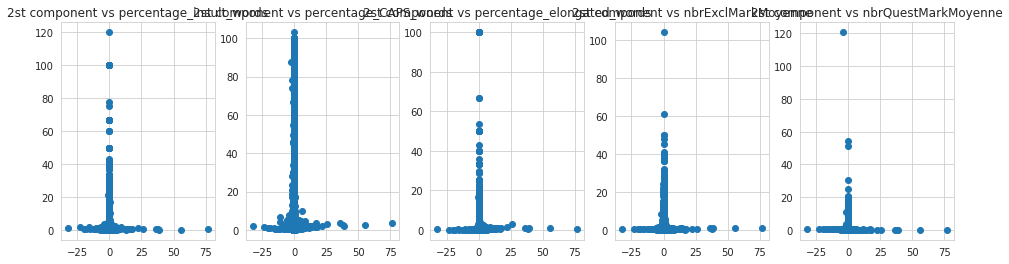

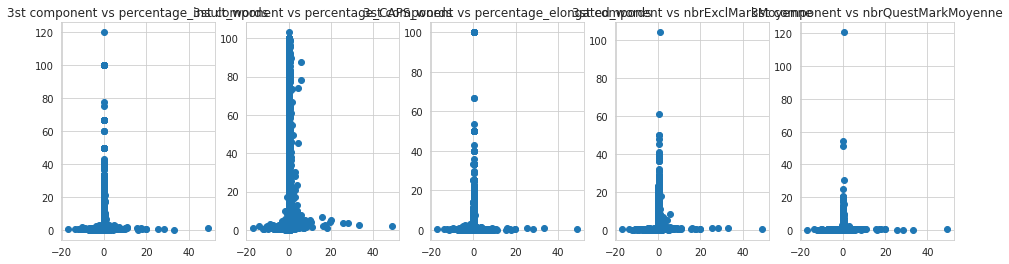

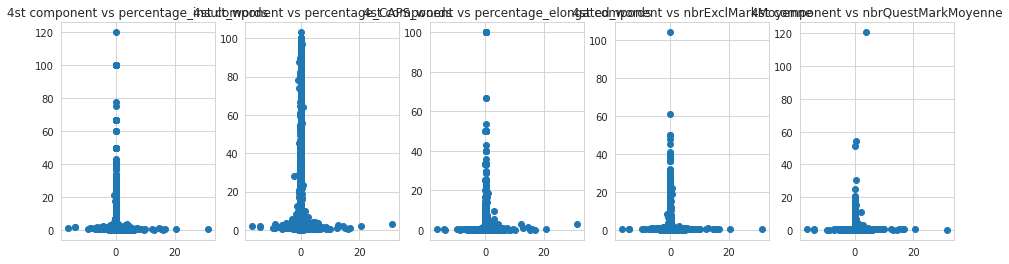

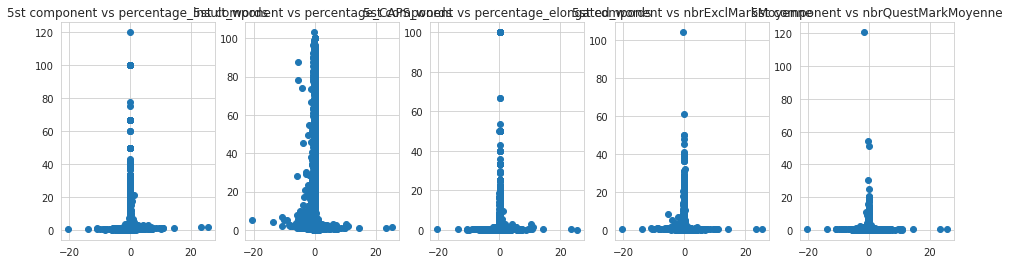

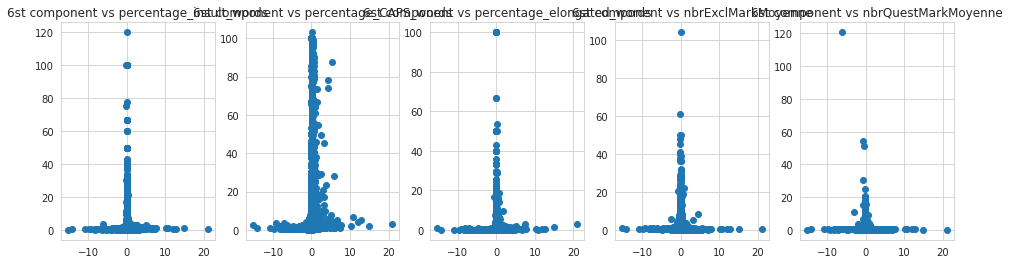

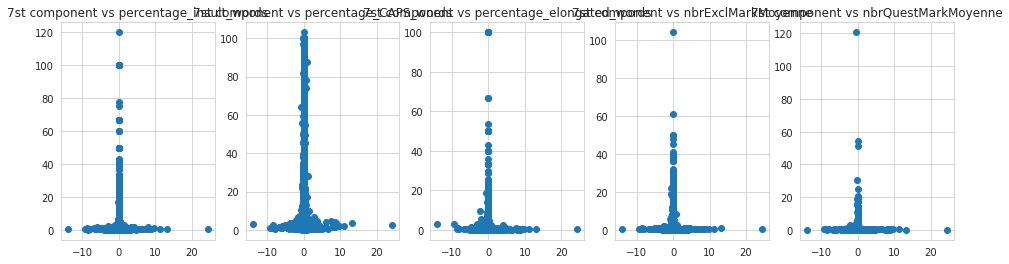

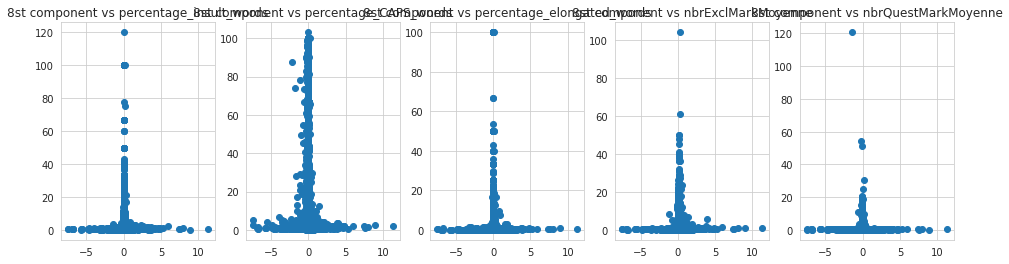

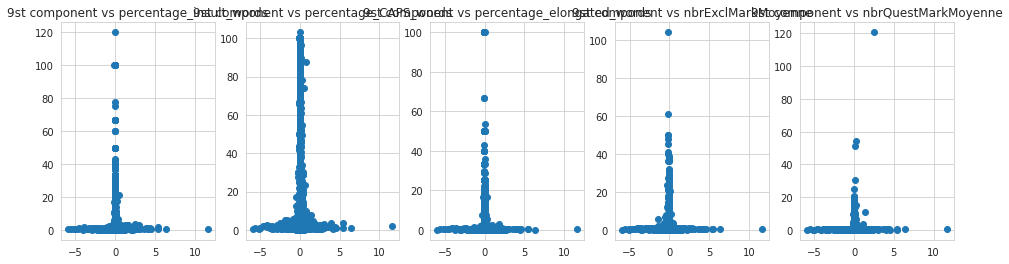

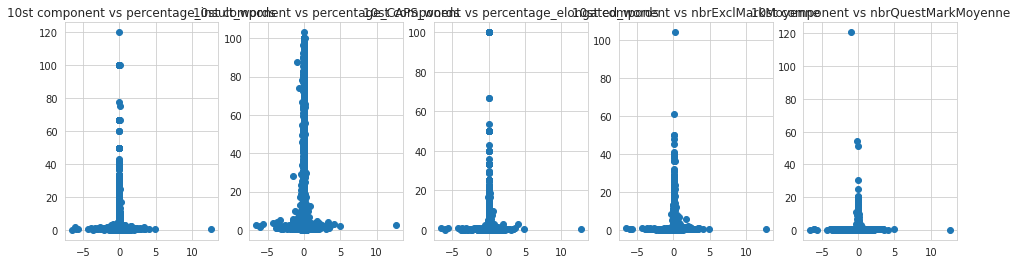

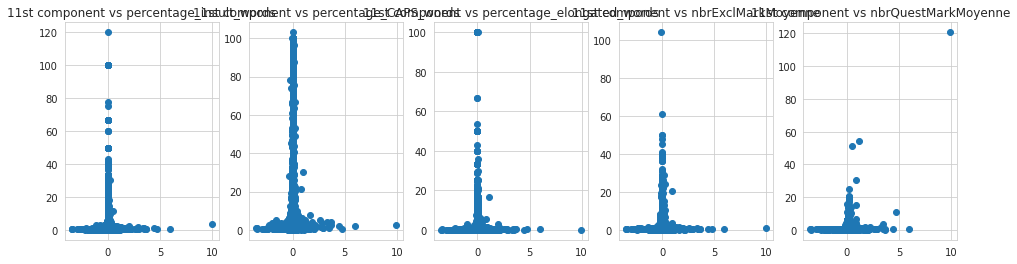

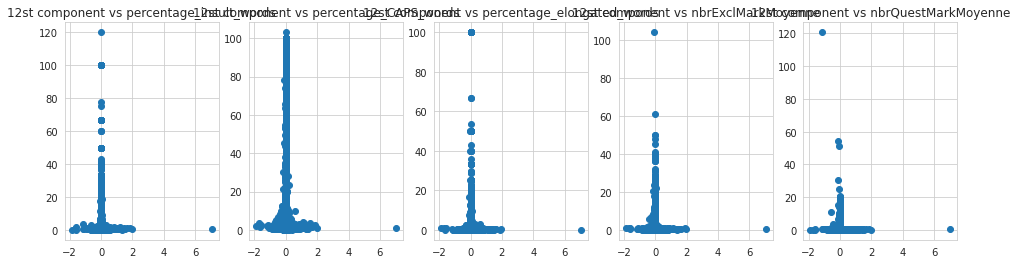

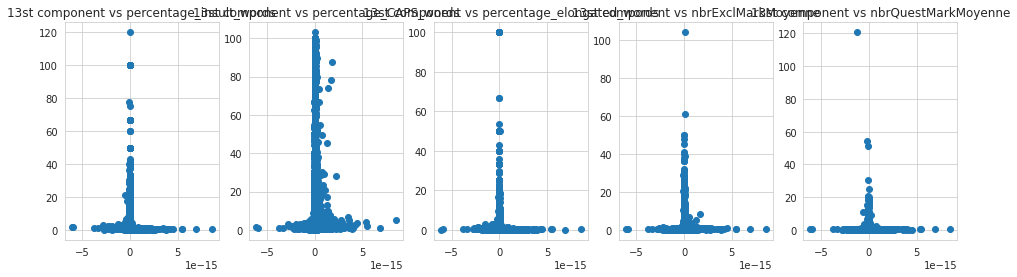

In [ ]:
#Selected variables from the correlation grahp, active variables as explained above.
act_var = [ "nbrMot", "nbrMotInsulte", "nbrMotAllong", "nbrMotMAJ", "nbrExclMark", "nbrQuestMark", "thread_count", "comment_count", "message_count", "discussion_count", "distinct_authors_count", "authors_3channels_count", "liked_authors_count"]
X_projec, pca = pca_process(result, act_var)

components_analysis(result, act_var, ['percentage_insult_words',	'percentage_CAPS_words',	'percentage_elongated_words',	'nbrExclMarkMoyenne',	'nbrQuestMarkMoyenne'])

With only 2 componenets, with have 90.6 % of the variance of the dataset. The two first axis are uncorrelated with the mean number of insult words, elongated words as well as their percentages. We cannot interpret them in terms of average toxicity of a video.

(-30.0, 60.0)

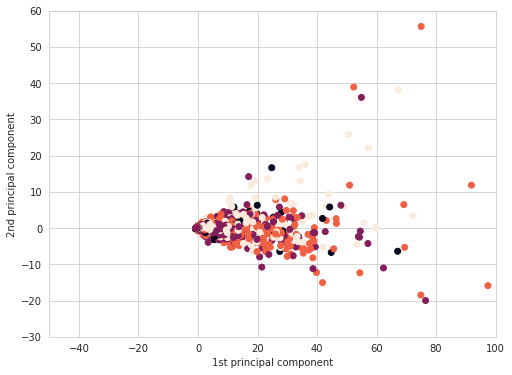

In [ ]:
plt.scatter(X_projec[:,0], X_projec[:,1], c = result['cluster_indexes'] )
plt.xlabel('1st principal component')
plt.ylabel('2nd principal component')

plt.xlim(-50, 100)
plt.ylim(-30, 60)

The PCA does not helps us to conclude since the clusters are mixed when we project the indiviudals on the two first principal components.

## Study per channel:
We couldn't conclude the study per video which is hard to interprete due to the large number of individuals.
Instead of considering each video individually, we consider channels as individuals in order to reduce the number of individuals. The features represent thus their homonymous features from the previous dataset averaged per video. In this dataset the features 'nbrMotInsulte'	to	'nbrQuestMark' and 'thread_count' to 'viewCount' are averages per video. 'nbrMotMoyenne'	to 'nbrQuestMarkMoyenne' are averages per video per commentary. We introduce the variable video_number that represents the number of videos per channel and thus the relative importance of each channel.

In [ ]:
data_channel=df.groupby(by=['channel_name','categorie_new', 'categ_inst']).mean().reset_index()

dc = df.groupby(by=['channel_name','categorie_new', 'categ_inst']).count().reset_index()

num_vid = dc['video_id']
dc.columns = ['channel_name', 'categorie_new', 'categ_inst', 'video_id_court',
       'video_number', 'channel_id', 'nbrMot', 'nbrMotInsulte', 'nbrMotAllong',
       'nbrMotMAJ', 'nbrExclMark', 'nbrQuestMark', 'nbrMotMoyenne',
       'nbrMotInsulteMoyenne', 'nbrMotAllongMoyenne', 'nbrMotMAJMoyenne',
       'nbrExclMarkMoyenne', 'nbrQuestMarkMoyenne', 'thread_count',
       'comment_count', 'message_count', 'discussion_count',
       'distinct_authors_count', 'authors_3channels_count',
       'liked_authors_count', 'subscriberCount', 'viewCount']

num_vid = dc['video_number']
result = pd.concat([data_channel, num_vid], axis=1, sort=False)
result.rename(columns= {"video_id": "video_number"})
data_channel = result
data_channel = pd.get_dummies(data_channel, columns = ['categorie_new', 'categ_inst'])
data_channel['percentage_insult_words'] = df.apply(lambda x: x['nbrMot'] if x['nbrMot'] == 0 else x['nbrMotInsulte']/x['nbrMot']*100, axis=1)
data_channel['percentage_CAPS_words'] = df.apply(lambda x: x['nbrMot'] if x['nbrMot'] ==0 else x['nbrMotMAJ']/x['nbrMot']*100, axis=1)
data_channel['percentage_elongated_words'] = df.apply(lambda x: x['nbrMot'] if x['nbrMot'] == 0 else x['nbrMotAllong']/x['nbrMot']*100, axis=1)
channel_name = data_channel['channel_name']
data_channel.set_index('channel_name', inplace = True)
data_channel


,nbrMot,nbrMotInsulte,nbrMotAllong,nbrMotMAJ,nbrExclMark,nbrQuestMark,nbrMotMoyenne,nbrMotInsulteMoyenne,nbrMotAllongMoyenne,nbrMotMAJMoyenne,nbrExclMarkMoyenne,nbrQuestMarkMoyenne,thread_count,comment_count,message_count,discussion_count,distinct_authors_count,authors_3channels_count,liked_authors_count,subscriberCount,viewCount,video_number,categorie_new_Core,categorie_new_Niche,categorie_new_Partisan,categ_inst_Alternatif,categ_inst_Presse magazine,categ_inst_Presse nationale,categ_inst_Presse_regionale,categ_inst_Pure Players,categ_inst_TV,percentage_insult_words,percentage_CAPS_words,percentage_elongated_words
channel_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20MinutesFR,598.217687,5.935374,1.836735,11.615646,13.472789,7.284014,20.373181,0.155548,0.084704,0.502273,0.523425,0.353078,10.704082,12.035714,22.739796,2.534014,14.493197,6.420068,5.292517,16219.0,8683792.0,588,1,0,0,0,0,1,0,0,0,0.472069,3.802780,0.104904
Acrimed,405.709091,2.981818,0.472727,3.490909,4.981818,3.145455,24.060274,0.129163,0.028816,0.351706,0.489666,0.282277,7.272727,3.072727,10.345455,1.254545,8.363636,5.709091,3.381818,5278.0,529390.0,55,0,0,1,1,0,0,0,0,0,7.142857,3.571429,0.000000
AgoraVoxFrance,2635.357542,12.296089,18.374302,74.648045,135.983240,26.709497,18.133663,0.091186,0.056802,0.409553,0.714712,0.186400,183.821229,61.636872,245.458101,13.614525,197.703911,7.229050,59.715084,154937.0,241435040.0,179,0,0,1,0,0,0,0,1,0,1.787592,1.472135,0.236593
Alternatives Economiques Officiel,205.903226,0.612903,0.387097,1.806452,4.290323,2.032258,33.522601,0.052970,0.093050,0.381517,0.696083,0.300347,4.161290,1.677419,5.838710,0.774194,4.548387,2.677419,1.516129,2724.0,199290.0,31,0,0,1,0,1,0,0,0,0,0.000000,50.000000,25.000000
AtlanticoFr,5460.000000,97.000000,6.000000,198.000000,125.000000,54.000000,34.339620,0.610063,0.037736,1.245283,0.786164,0.339623,152.000000,7.000000,159.000000,5.000000,104.000000,43.000000,22.000000,74.0,261055.0,1,1,0,0,0,0,0,0,1,0,0.407056,2.442334,0.135685
CNEWS,789.199441,7.219665,1.945363,16.293184,16.084022,8.358212,27.202790,0.299919,0.075035,0.711437,0.827864,0.362015,13.214413,11.078324,24.292737,2.726257,13.779553,8.155307,5.126369,189971.0,132125693.0,8950,1,0,0,0,0,0,0,0,1,0.000000,0.000000,0.000000
Causeur,718.093023,3.651163,1.186047,9.453488,9.569767,4.581395,44.599867,0.160446,0.080686,0.649699,0.594073,0.300204,7.034884,6.465116,13.500000,1.569767,7.604651,5.058140,2.581395,2619.0,937396.0,86,0,0,1,0,0,0,0,1,0,0.000000,0.000000,6.250000
Contre Info,864.478261,7.130435,2.869565,15.347826,10.956522,8.608696,28.155413,0.282833,0.127988,0.668394,0.445731,0.389113,11.260870,10.782609,22.043478,3.043478,14.826087,7.043478,5.826087,202.0,207245.0,23,0,0,1,1,0,0,0,0,0,1.485149,2.970297,0.000000
Corse Net Infos,342.846847,3.585586,0.621622,6.288288,4.333333,3.162162,23.108038,0.218989,0.029568,0.644651,0.659506,0.110983,2.513514,4.918919,7.432432,0.684685,3.108108,1.306306,0.666667,1124.0,741798.0,111,0,1,0,0,0,0,0,1,0,0.000000,1.570681,0.000000


In [ ]:
dc2 = df.groupby(by=['channel_name','categorie_new', 'categ_inst']).count().reset_index()
dc2 = pd.concat([dc2['channel_name'],dc2['categorie_new'], dc2['categ_inst']], axis=1, sort=False)
dc2

,channel_name,categorie_new,categ_inst
0,20MinutesFR,Core,Presse nationale
1,Acrimed,Partisan,Alternatif
2,AgoraVoxFrance,Partisan,Pure Players
3,Alternatives Economiques Officiel,Partisan,Presse magazine
4,AtlanticoFr,Core,Pure Players
5,CNEWS,Core,TV
6,Causeur,Partisan,Pure Players
7,Contre Info,Partisan,Alternatif
8,Corse Net Infos,Niche,Pure Players
9,Corse-Matin Presse,Niche,Presse_regionale


In [ ]:
channel_name

0                               20MinutesFR
1                                   Acrimed
2                            AgoraVoxFrance
3         Alternatives Economiques Officiel
4                               AtlanticoFr
5                                     CNEWS
6                                   Causeur
7                               Contre Info
8                           Corse Net Infos
9                        Corse-Matin Presse
10                   Courrier international
11    DNA - DerniÌå_res Nouvelles d'Alsace
12                          Dauphine_libere
13                              Fakirpresse
14                       Famille_chretienne
15                                Fdesouche
16                 France Net Infos journal
17                              France-Soir
18                                     Gala
19                                 Humanite
20                                L'Express
21                                      LCI
22                              

## K-Means

In [ ]:
silhouette_index(data_channel, n_init=40)

For n = 2 Silhouette_score: 0.8316633360049861
For n = 3 Silhouette_score: 0.816457120159766
For n = 4 Silhouette_score: 0.8282030634020416
For n = 5 Silhouette_score: 0.8175203408416756
For n = 6 Silhouette_score: 0.7900107381527909
For n = 7 Silhouette_score: 0.7591974722965845
For n = 8 Silhouette_score: 0.7498444693339337
For n = 9 Silhouette_score: 0.7457142772801575
For n = 10 Silhouette_score: 0.7169260315083921
For n = 11 Silhouette_score: 0.7026772054269437
For n = 12 Silhouette_score: 0.6782617031139061
For n = 13 Silhouette_score: 0.6265508327828411
For n = 14 Silhouette_score: 0.6085332434327941
For n = 15 Silhouette_score: 0.604000877796698
For n = 16 Silhouette_score: 0.5768790415832608
For n = 17 Silhouette_score: 0.566872026147898
For n = 18 Silhouette_score: 0.5670576723983171
For n = 19 Silhouette_score: 0.5548256137377398


In [ ]:
kmeans_multiple = KMeans(n_clusters=2,n_init=40,init='random').fit(data_channel)
kmeans_multiple.labels_

array([0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [ ]:
kmeans_indexes = kmeans_multiple.labels_
df_k_means = pd.DataFrame(kmeans_indexes,columns = ['KMeans_indexes'])
df_kmeans = pd.concat([channel_name, df_k_means], axis=1, sort=False)
df_kmeans.set_index('channel_name', inplace = True)
df_kmeans



,KMeans_indexes
channel_name,
20MinutesFR,0
Acrimed,0
AgoraVoxFrance,1
Alternatives Economiques Officiel,0
AtlanticoFr,0
CNEWS,1
Causeur,0
Contre Info,0
Corse Net Infos,0


In [ ]:
data_channel_kmeans = pd.concat([data_channel, df_kmeans], axis=1, sort=False)
data_channel_kmeans

,nbrMot,nbrMotInsulte,nbrMotAllong,nbrMotMAJ,nbrExclMark,nbrQuestMark,nbrMotMoyenne,nbrMotInsulteMoyenne,nbrMotAllongMoyenne,nbrMotMAJMoyenne,nbrExclMarkMoyenne,nbrQuestMarkMoyenne,thread_count,comment_count,message_count,discussion_count,distinct_authors_count,authors_3channels_count,liked_authors_count,subscriberCount,viewCount,video_number,categorie_new_Core,categorie_new_Niche,categorie_new_Partisan,categ_inst_Alternatif,categ_inst_Presse magazine,categ_inst_Presse nationale,categ_inst_Presse_regionale,categ_inst_Pure Players,categ_inst_TV,percentage_insult_words,percentage_CAPS_words,percentage_elongated_words,KMeans_indexes
channel_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20MinutesFR,598.217687,5.935374,1.836735,11.615646,13.472789,7.284014,20.373181,0.155548,0.084704,0.502273,0.523425,0.353078,10.704082,12.035714,22.739796,2.534014,14.493197,6.420068,5.292517,16219.0,8683792.0,588,1,0,0,0,0,1,0,0,0,0.472069,3.802780,0.104904,0
Acrimed,405.709091,2.981818,0.472727,3.490909,4.981818,3.145455,24.060274,0.129163,0.028816,0.351706,0.489666,0.282277,7.272727,3.072727,10.345455,1.254545,8.363636,5.709091,3.381818,5278.0,529390.0,55,0,0,1,1,0,0,0,0,0,7.142857,3.571429,0.000000,0
AgoraVoxFrance,2635.357542,12.296089,18.374302,74.648045,135.983240,26.709497,18.133663,0.091186,0.056802,0.409553,0.714712,0.186400,183.821229,61.636872,245.458101,13.614525,197.703911,7.229050,59.715084,154937.0,241435040.0,179,0,0,1,0,0,0,0,1,0,1.787592,1.472135,0.236593,1
Alternatives Economiques Officiel,205.903226,0.612903,0.387097,1.806452,4.290323,2.032258,33.522601,0.052970,0.093050,0.381517,0.696083,0.300347,4.161290,1.677419,5.838710,0.774194,4.548387,2.677419,1.516129,2724.0,199290.0,31,0,0,1,0,1,0,0,0,0,0.000000,50.000000,25.000000,0
AtlanticoFr,5460.000000,97.000000,6.000000,198.000000,125.000000,54.000000,34.339620,0.610063,0.037736,1.245283,0.786164,0.339623,152.000000,7.000000,159.000000,5.000000,104.000000,43.000000,22.000000,74.0,261055.0,1,1,0,0,0,0,0,0,1,0,0.407056,2.442334,0.135685,0
CNEWS,789.199441,7.219665,1.945363,16.293184,16.084022,8.358212,27.202790,0.299919,0.075035,0.711437,0.827864,0.362015,13.214413,11.078324,24.292737,2.726257,13.779553,8.155307,5.126369,189971.0,132125693.0,8950,1,0,0,0,0,0,0,0,1,0.000000,0.000000,0.000000,1
Causeur,718.093023,3.651163,1.186047,9.453488,9.569767,4.581395,44.599867,0.160446,0.080686,0.649699,0.594073,0.300204,7.034884,6.465116,13.500000,1.569767,7.604651,5.058140,2.581395,2619.0,937396.0,86,0,0,1,0,0,0,0,1,0,0.000000,0.000000,6.250000,0
Contre Info,864.478261,7.130435,2.869565,15.347826,10.956522,8.608696,28.155413,0.282833,0.127988,0.668394,0.445731,0.389113,11.260870,10.782609,22.043478,3.043478,14.826087,7.043478,5.826087,202.0,207245.0,23,0,0,1,1,0,0,0,0,0,1.485149,2.970297,0.000000,0
Corse Net Infos,342.846847,3.585586,0.621622,6.288288,4.333333,3.162162,23.108038,0.218989,0.029568,0.644651,0.659506,0.110983,2.513514,4.918919,7.432432,0.684685,3.108108,1.306306,0.666667,1124.0,741798.0,111,0,1,0,0,0,0,0,1,0,0.000000,1.570681,0.000000,0


The optimal number of clusters is n = 2 with a silouhette score of 0.8316633360069545. However, there is not a significant difference between the silouhette scores when varying the number of clusters.

## Hierarchical clustering

We may thus know which indiviudals we have in these clusters by conducting a hierarchical clustering. If we cut the tree for a distance greater than 16, we get the constitution of the three classes predicted by the K-means. The first class totalizes is majoritary with 50 media channels, the second class is minoritary with only 8 channels. If we commit to the classes predicted by mean shift, we must cut the tree for a distance greater than 14. This yields to a majoritary class of 33 individuals, three intermediary classes of 9, 8 and 7 channels respectively and a singleton which is "alternatives economiques officiel".

                                         nbrMot  ...  percentage_elongated_words
channel_name                                     ...                            
20MinutesFR                           -0.238988  ...                   -0.253835
Acrimed                               -0.367490  ...                   -0.280060
AgoraVoxFrance                         1.120824  ...                   -0.220914
Alternatives Economiques Officiel     -0.500862  ...                    5.969686
AtlanticoFr                            3.006301  ...                   -0.246140
CNEWS                                 -0.111506  ...                   -0.280060
Causeur                               -0.158970  ...                    1.282376
Contre Info                           -0.061256  ...                   -0.280060
Corse Net Infos                       -0.409451  ...                   -0.280060
Corse-Matin Presse                    -0.593531  ...                   -0.280060
Courrier international      

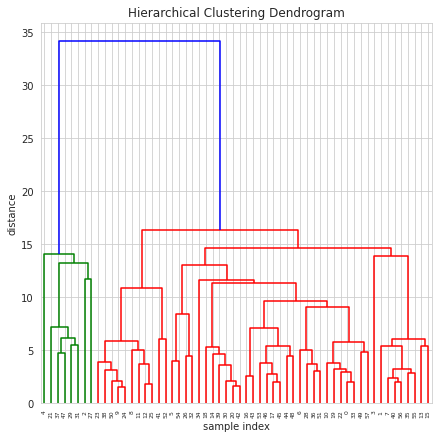

array([[  9.        ,  24.        ,   1.5368319 ,   2.        ],
       [ 20.        ,  42.        ,   1.62876642,   2.        ],
       [ 12.        ,  25.        ,   1.77128702,   2.        ],
       [ 40.        ,  56.        ,   1.95079916,   2.        ],
       [ 17.        ,  45.        ,   1.97162551,   2.        ],
       [  0.        ,  33.        ,   2.00727168,   2.        ],
       [ 50.        ,  58.        ,   2.0793399 ,   3.        ],
       [ 30.        ,  59.        ,   2.08762062,   3.        ],
       [  7.        ,  61.        ,   2.38338521,   3.        ],
       [ 16.        ,  43.        ,   2.57391833,   2.        ],
       [ 46.        ,  62.        ,   2.74079811,   3.        ],
       [ 35.        ,  55.        ,   2.80740876,   2.        ],
       [ 22.        ,  63.        ,   2.90006882,   3.        ],
       [ 36.        ,  51.        ,   3.04071627,   2.        ],
       [ 38.        ,  64.        ,   3.1219238 ,   4.        ],
       [ 19.        ,  70

In [ ]:
hierarchical_clustering(data_channel)

## Mean shift
Optimal number of clusters n = 5 for a silhouette score of 0.8175203408416756.

In [ ]:
ms = mean_shift(data_channel)
ms.labels_

[[5.11095033e+02 5.11765308e+00 1.20420053e+00 1.24340945e+01
  9.85697945e+00 4.81052719e+00 2.65903416e+01 1.67454764e-01
  9.86301062e-02 9.18129542e-01 6.34177694e-01 2.53138082e-01
  1.00465443e+01 4.77515112e+00 1.48216955e+01 1.32057659e+00
  9.87660501e+00 4.63685222e+00 2.95393638e+00 5.01397674e+03
  2.82263826e+06 2.03581395e+02 4.18604651e-01 2.32558140e-01
  3.48837209e-01 2.09302326e-01 9.30232558e-02 2.55813953e-01
  2.32558140e-01 2.09302326e-01 0.00000000e+00 9.89532494e-01
  2.53510368e+00 1.44681304e+00]
 [1.76670417e+03 1.29077037e+01 5.14300109e+00 2.94219198e+01
  2.52206227e+01 1.59433093e+01 2.60592965e+01 1.72870203e-01
  8.09400281e-02 6.74116685e-01 6.75163086e-01 2.74167492e-01
  3.08058569e+01 2.85713798e+01 5.93772367e+01 5.27039547e+00
  3.76459919e+01 1.47697429e+01 1.35061329e+01 1.16995250e+05
  3.81870735e+07 1.25775000e+03 1.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 2.50000000e-01 0.00000000e+00
  1.25000000e-01 3.75000000e-01 2.500

array([0, 0, 3, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 4, 1,
       0, 0, 0, 0, 2, 2, 0, 4, 0, 3, 4, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [ ]:
mean_shift_indexes = ms.labels_
df_ms = pd.DataFrame(mean_shift_indexes,columns = ['Mean_shift_indexes'])
df_ms = pd.concat([channel_name, df_ms], axis=1, sort=False)
df_ms.set_index('channel_name', inplace = True)
df_ms

,Mean_shift_indexes
channel_name,
20MinutesFR,0
Acrimed,0
AgoraVoxFrance,3
Alternatives Economiques Officiel,0
AtlanticoFr,0
CNEWS,2
Causeur,0
Contre Info,0
Corse Net Infos,0




*   Cluster 0: Majoritary.
*   Cluster 1: franceinfo, StreetPress, ParisMatch, Obs, Mediapart, LCI, Francesoir.
*   Cluster 2: CNews, Le Figaro, Le Monde.
*   Cluster 3: AgoraVox France, Le Huff Post.
*   Cluster 4: L'express, Le parisien and l'équipe.

The cluster 0 is majoritary while the 4 other concentrate the channels that submitted the most videos except for StreetPress and AgoraVoxFrance. We observe that all of them are either natioanal press, pure players or TV. The cluster 0 regroups thus all the "small" media channels except for 20minutesFR.
 The cluster 1 regroups classical news channels that present the information in  a neutral way.
The cluster 2 contains politized medias like  Le Figaro which is right wing and Le Monde which is left wing while CNews offers more debates.
 The cluster 3 contains agoraVox France and LeHuff Post which are both pure players.
The cluster 4 regroups L'express and Le Parisien which are both center medias politically with L'équipe which is a sport media.








In [ ]:
data_channel_indexes = pd.concat([data_channel_kmeans, df_ms], axis=1, sort=False)
data_channel_indexes

,nbrMot,nbrMotInsulte,nbrMotAllong,nbrMotMAJ,nbrExclMark,nbrQuestMark,nbrMotMoyenne,nbrMotInsulteMoyenne,nbrMotAllongMoyenne,nbrMotMAJMoyenne,nbrExclMarkMoyenne,nbrQuestMarkMoyenne,thread_count,comment_count,message_count,discussion_count,distinct_authors_count,authors_3channels_count,liked_authors_count,subscriberCount,viewCount,video_number,categorie_new_Core,categorie_new_Niche,categorie_new_Partisan,categ_inst_Alternatif,categ_inst_Presse magazine,categ_inst_Presse nationale,categ_inst_Presse_regionale,categ_inst_Pure Players,categ_inst_TV,percentage_insult_words,percentage_CAPS_words,percentage_elongated_words,KMeans_indexes,Mean_shift_indexes
channel_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20MinutesFR,598.217687,5.935374,1.836735,11.615646,13.472789,7.284014,20.373181,0.155548,0.084704,0.502273,0.523425,0.353078,10.704082,12.035714,22.739796,2.534014,14.493197,6.420068,5.292517,16219.0,8683792.0,588,1,0,0,0,0,1,0,0,0,0.472069,3.802780,0.104904,0,0
Acrimed,405.709091,2.981818,0.472727,3.490909,4.981818,3.145455,24.060274,0.129163,0.028816,0.351706,0.489666,0.282277,7.272727,3.072727,10.345455,1.254545,8.363636,5.709091,3.381818,5278.0,529390.0,55,0,0,1,1,0,0,0,0,0,7.142857,3.571429,0.000000,0,0
AgoraVoxFrance,2635.357542,12.296089,18.374302,74.648045,135.983240,26.709497,18.133663,0.091186,0.056802,0.409553,0.714712,0.186400,183.821229,61.636872,245.458101,13.614525,197.703911,7.229050,59.715084,154937.0,241435040.0,179,0,0,1,0,0,0,0,1,0,1.787592,1.472135,0.236593,1,3
Alternatives Economiques Officiel,205.903226,0.612903,0.387097,1.806452,4.290323,2.032258,33.522601,0.052970,0.093050,0.381517,0.696083,0.300347,4.161290,1.677419,5.838710,0.774194,4.548387,2.677419,1.516129,2724.0,199290.0,31,0,0,1,0,1,0,0,0,0,0.000000,50.000000,25.000000,0,0
AtlanticoFr,5460.000000,97.000000,6.000000,198.000000,125.000000,54.000000,34.339620,0.610063,0.037736,1.245283,0.786164,0.339623,152.000000,7.000000,159.000000,5.000000,104.000000,43.000000,22.000000,74.0,261055.0,1,1,0,0,0,0,0,0,1,0,0.407056,2.442334,0.135685,0,0
CNEWS,789.199441,7.219665,1.945363,16.293184,16.084022,8.358212,27.202790,0.299919,0.075035,0.711437,0.827864,0.362015,13.214413,11.078324,24.292737,2.726257,13.779553,8.155307,5.126369,189971.0,132125693.0,8950,1,0,0,0,0,0,0,0,1,0.000000,0.000000,0.000000,1,2
Causeur,718.093023,3.651163,1.186047,9.453488,9.569767,4.581395,44.599867,0.160446,0.080686,0.649699,0.594073,0.300204,7.034884,6.465116,13.500000,1.569767,7.604651,5.058140,2.581395,2619.0,937396.0,86,0,0,1,0,0,0,0,1,0,0.000000,0.000000,6.250000,0,0
Contre Info,864.478261,7.130435,2.869565,15.347826,10.956522,8.608696,28.155413,0.282833,0.127988,0.668394,0.445731,0.389113,11.260870,10.782609,22.043478,3.043478,14.826087,7.043478,5.826087,202.0,207245.0,23,0,0,1,1,0,0,0,0,0,1.485149,2.970297,0.000000,0,0
Corse Net Infos,342.846847,3.585586,0.621622,6.288288,4.333333,3.162162,23.108038,0.218989,0.029568,0.644651,0.659506,0.110983,2.513514,4.918919,7.432432,0.684685,3.108108,1.306306,0.666667,1124.0,741798.0,111,0,1,0,0,0,0,0,1,0,0.000000,1.570681,0.000000,0,0


In [ ]:
data_channel_indexes.groupby(by =['Mean_shift_indexes']).mean()

,nbrMot,nbrMotInsulte,nbrMotAllong,nbrMotMAJ,nbrExclMark,nbrQuestMark,nbrMotMoyenne,nbrMotInsulteMoyenne,nbrMotAllongMoyenne,nbrMotMAJMoyenne,nbrExclMarkMoyenne,nbrQuestMarkMoyenne,thread_count,comment_count,message_count,discussion_count,distinct_authors_count,authors_3channels_count,liked_authors_count,subscriberCount,viewCount,video_number,categorie_new_Core,categorie_new_Niche,categorie_new_Partisan,categ_inst_Alternatif,categ_inst_Presse magazine,categ_inst_Presse nationale,categ_inst_Presse_regionale,categ_inst_Pure Players,categ_inst_TV,percentage_insult_words,percentage_CAPS_words,percentage_elongated_words,KMeans_indexes
Mean_shift_indexes,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,511.095033,5.117653,1.204201,12.434095,9.856979,4.810527,26.590342,0.167455,0.098630,0.918130,0.634178,0.253138,10.046544,4.775151,14.821695,1.320577,9.876605,4.636852,2.953936,5013.976744,2.822638e+06,203.581395,0.418605,0.232558,0.348837,0.209302,0.093023,0.255814,0.232558,0.209302,0.000000,0.989532,2.535104,1.446813,0.000000
1,1990.614842,14.488529,5.774554,32.736770,28.029416,17.927367,26.437133,0.170990,0.081280,0.665351,0.652330,0.277780,34.534243,32.150034,66.684277,5.890673,42.221756,16.367702,15.161751,130618.857143,4.084970e+07,1351.571429,1.000000,0.000000,0.000000,0.000000,0.285714,0.000000,0.000000,0.428571,0.285714,0.515038,3.465165,0.119687,0.000000
2,3232.844384,12.121387,8.187221,43.112462,36.859546,29.801952,27.074904,0.183908,0.073766,0.556660,0.624430,0.311041,39.177769,60.437264,99.615033,11.018577,56.037041,29.076991,22.502196,312919.666667,1.356105e+08,5019.666667,1.000000,0.000000,0.000000,0.000000,0.000000,0.666667,0.000000,0.000000,0.333333,0.127505,0.629051,0.264328,1.000000
3,2727.599701,16.405971,13.592519,54.891422,88.177576,27.066964,20.216378,0.126576,0.067107,0.392210,0.569961,0.211866,113.973248,61.485913,175.459161,12.433211,130.178254,21.675019,42.497495,247429.500000,2.334142e+08,2660.000000,0.500000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.925837,1.040457,0.374625,1.000000
4,1465.730065,12.556260,5.075533,24.139158,28.538435,14.515589,20.101435,0.149653,0.074686,0.422782,0.505420,0.205854,29.611944,32.118692,61.730636,6.102280,38.073150,17.212847,13.622470,145237.333333,8.002108e+07,2502.666667,0.666667,0.333333,0.000000,0.000000,0.333333,0.333333,0.333333,0.000000,0.000000,0.255754,0.000000,0.127877,0.666667


 The cluster 0 has the highest percentage of insult words and elongated words while having a high percentage of capital letter words. It is the most toxic one.
 The cluster 1 has an average percentage of insult words, the highest percentage of capital letter words and a small percentage of elogated words. It is thus slightly toxic with less propensity for insults but a higher propensity of angry comments.
 The cluster 2 has the smallest percentage of insult words with low percentages of insult capital letters words and elongated words. It is one of the less toxic.
 The cluster 3 has a high percentage of insult words with medium percentage of capital letter words and elongated words. It is a medium toxicity.
 The cluster 4 has low percentages for elongated words and insult words while having 0 capital letters words. It is the less toxic one.

## PCA

In [ ]:
# Heatmap
corr = data_channel.corr()
corr


,nbrMot,nbrMotInsulte,nbrMotAllong,nbrMotMAJ,nbrExclMark,nbrQuestMark,nbrMotMoyenne,nbrMotInsulteMoyenne,nbrMotAllongMoyenne,nbrMotMAJMoyenne,nbrExclMarkMoyenne,nbrQuestMarkMoyenne,thread_count,comment_count,message_count,discussion_count,distinct_authors_count,authors_3channels_count,liked_authors_count,subscriberCount,viewCount,video_id,categorie_new_Core,categorie_new_Niche,categorie_new_Partisan,categ_inst_Alternatif,categ_inst_Presse magazine,categ_inst_Presse nationale,categ_inst_Presse_regionale,categ_inst_Pure Players,categ_inst_TV
nbrMot,1.000000,0.737097,0.859613,0.859271,0.810469,0.996373,0.175260,0.209203,-0.210279,-0.065453,-0.097522,0.198779,0.757037,0.860713,0.889264,0.899171,0.808483,0.946921,0.846251,0.737479,0.467083,0.159097,0.294063,-0.237542,-0.119832,-0.072038,-0.098179,-0.001634,-0.160428,0.253791,0.058949
nbrMotInsulte,0.737097,1.000000,0.518414,0.934725,0.760336,0.764339,0.126211,0.558245,-0.239066,-0.020218,0.013377,0.183591,0.740133,0.407098,0.657256,0.484395,0.618833,0.711327,0.538205,0.299814,0.202600,0.072565,0.256325,-0.172917,-0.134399,-0.074746,-0.104865,-0.108884,-0.109764,0.324610,0.053922
nbrMotAllong,0.859613,0.518414,1.000000,0.691943,0.834028,0.865252,-0.006332,0.021114,-0.168926,-0.080757,-0.117839,0.099562,0.831713,0.935837,0.972208,0.958661,0.949579,0.819765,0.990636,0.748771,0.663759,0.145028,0.218660,-0.225209,-0.046497,-0.084746,-0.098621,-0.022477,-0.134223,0.224175,0.131486
nbrMotMAJ,0.859271,0.934725,0.691943,1.000000,0.900469,0.879481,0.166635,0.468494,-0.238716,0.031454,0.045309,0.173419,0.866966,0.567531,0.814169,0.652500,0.783065,0.791106,0.718528,0.431216,0.332863,0.053894,0.234193,-0.221326,-0.067237,-0.035487,-0.101985,-0.067417,-0.157037,0.281212,0.072913
nbrExclMark,0.810469,0.760336,0.834028,0.900469,1.000000,0.837442,0.071350,0.270145,-0.261520,-0.035404,0.053838,0.118889,0.985170,0.648442,0.926900,0.736136,0.944032,0.708450,0.876616,0.498873,0.588305,0.088440,0.178009,-0.230844,0.003815,-0.084418,-0.066632,-0.089596,-0.154035,0.316416,0.070423
nbrQuestMark,0.996373,0.764339,0.865252,0.879481,0.837442,1.000000,0.152670,0.225720,-0.223533,-0.068992,-0.087779,0.198587,0.785722,0.854524,0.904009,0.897504,0.827784,0.951271,0.856325,0.727871,0.487331,0.166871,0.296447,-0.240266,-0.120102,-0.079340,-0.093870,-0.000734,-0.156723,0.250196,0.063197
nbrMotMoyenne,0.175260,0.126211,-0.006332,0.166635,0.071350,0.152670,1.000000,0.315482,0.125710,0.151817,0.445847,0.439667,0.000395,0.003836,0.002118,0.033727,-0.028002,0.110974,-0.015460,-0.029407,-0.137911,-0.045293,0.106467,-0.525963,0.342513,0.206573,-0.007032,0.305870,-0.493735,-0.026783,0.007352
nbrMotInsulteMoyenne,0.209203,0.558245,0.021114,0.468494,0.270145,0.225720,0.315482,1.000000,-0.069030,0.108447,0.307322,0.198589,0.240889,-0.057549,0.121100,0.013498,0.103425,0.199041,0.026846,-0.047977,-0.050115,0.106958,0.030539,-0.095788,0.049935,0.150939,-0.184371,-0.056282,-0.081775,0.069251,0.144127
nbrMotAllongMoyenne,-0.210279,-0.239066,-0.168926,-0.238716,-0.261520,-0.223533,0.125710,-0.069030,1.000000,-0.003196,0.140137,0.195824,-0.256771,-0.147146,-0.230907,-0.166872,-0.232888,-0.188364,-0.208460,-0.200507,-0.237443,-0.154153,0.084646,-0.014473,-0.081774,-0.062182,0.027536,0.232604,0.025043,-0.197585,-0.050838
nbrMotMAJMoyenne,-0.065453,-0.020218,-0.080757,0.031454,-0.035404,-0.068992,0.151817,0.108447,-0.003196,1.000000,0.336433,-0.254452,-0.035763,-0.090386,-0.066294,-0.090738,-0.058117,-0.076287,-0.080879,-0.088870,-0.088433,-0.069055,0.168103,-0.135631,-0.068644,-0.019485,-0.055637,0.228303,-0.126397,-0.045655,-0.015476


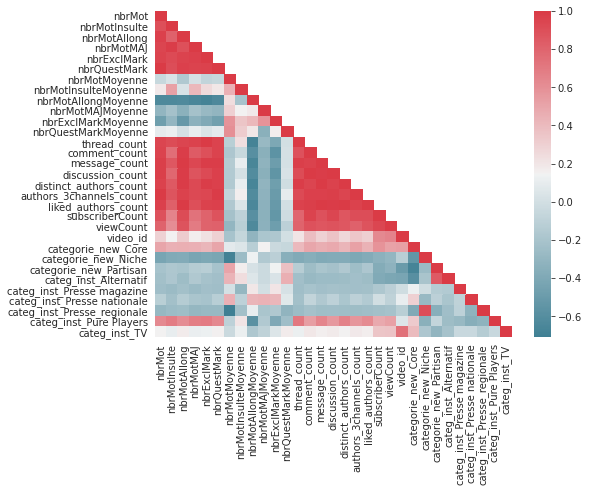

In [ ]:
plot_corr(corr)

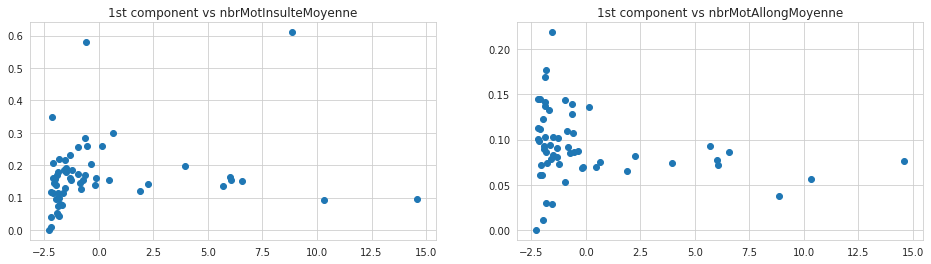

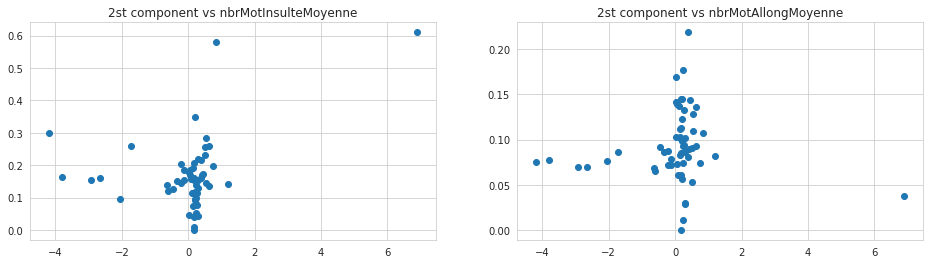

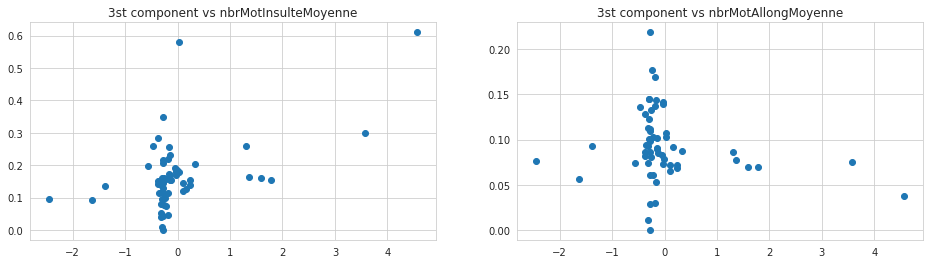

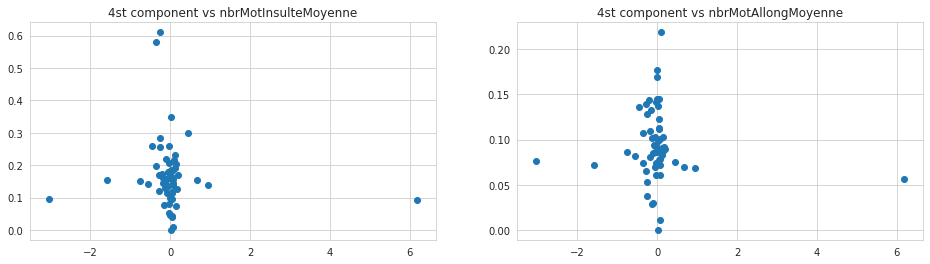

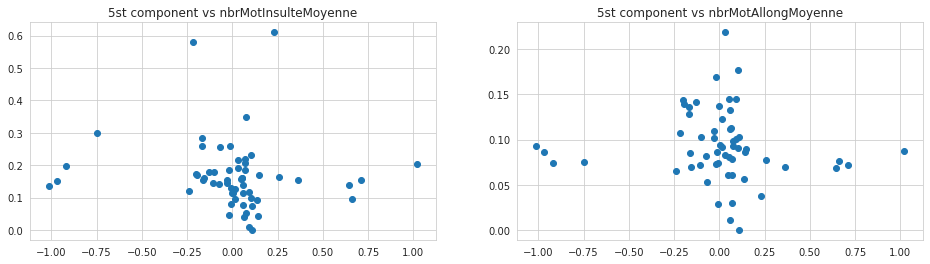

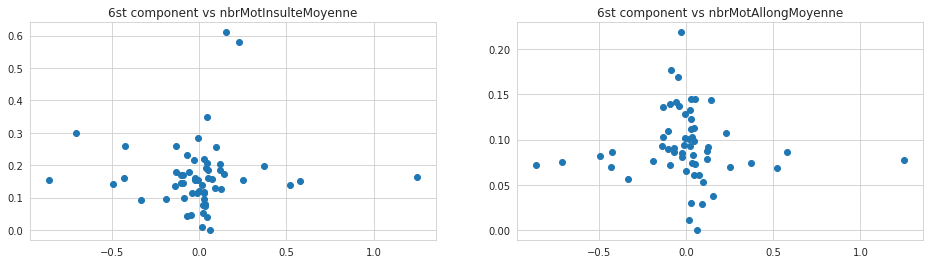

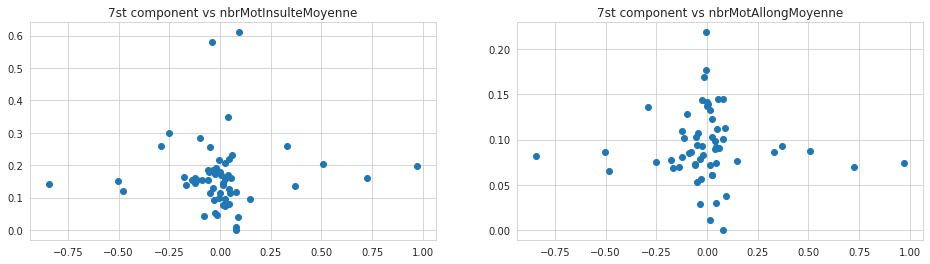

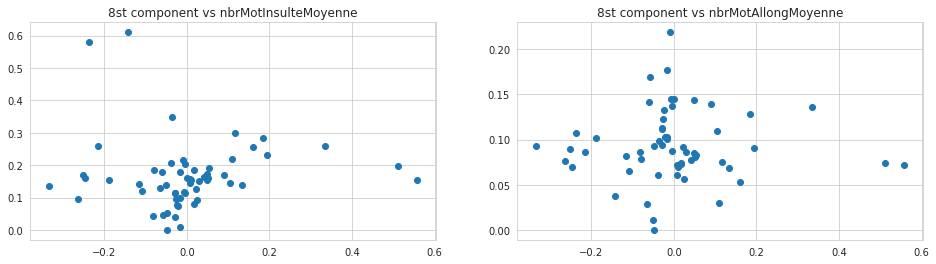

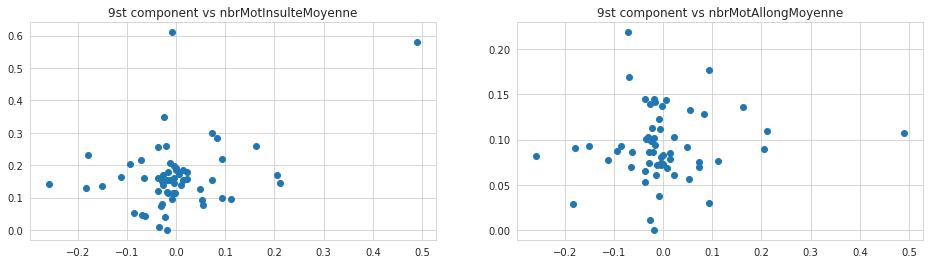

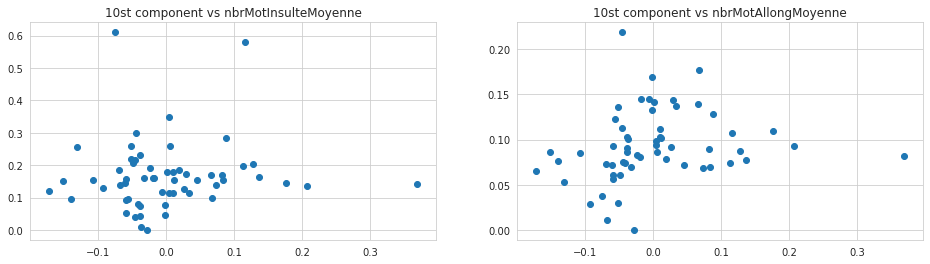

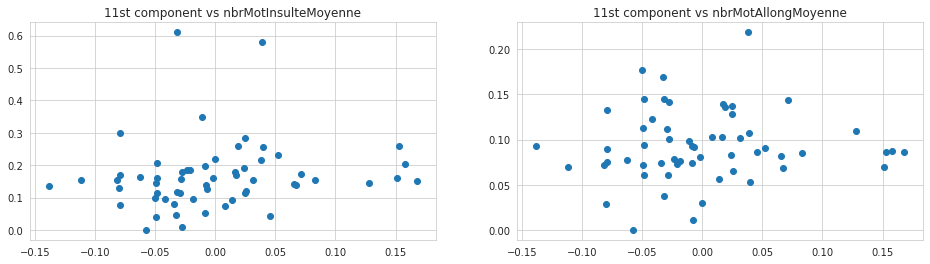

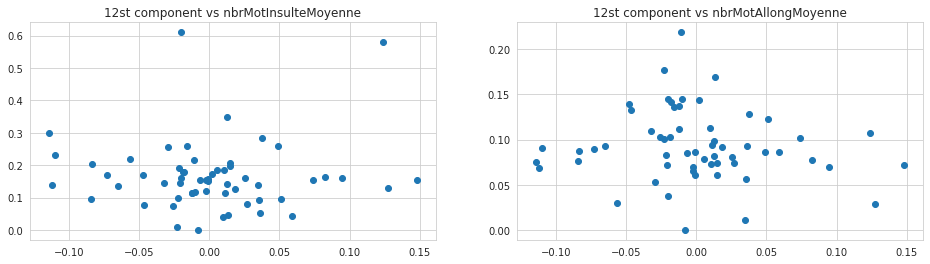

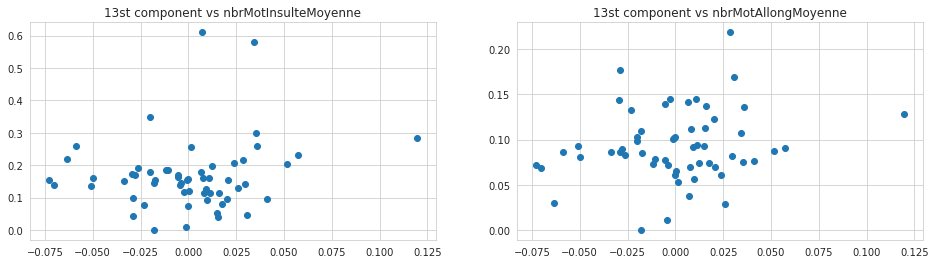

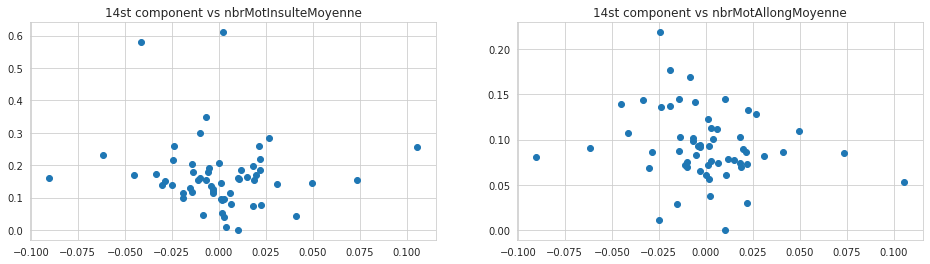

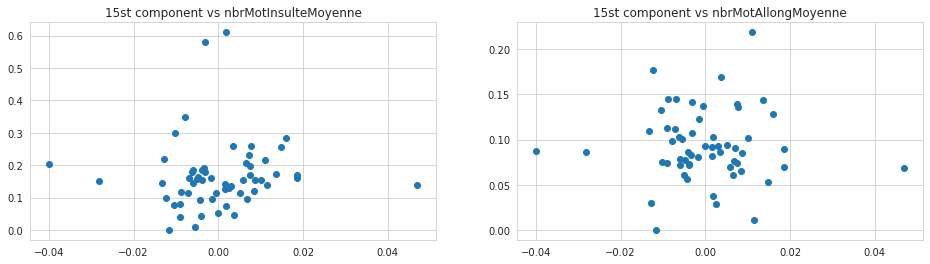

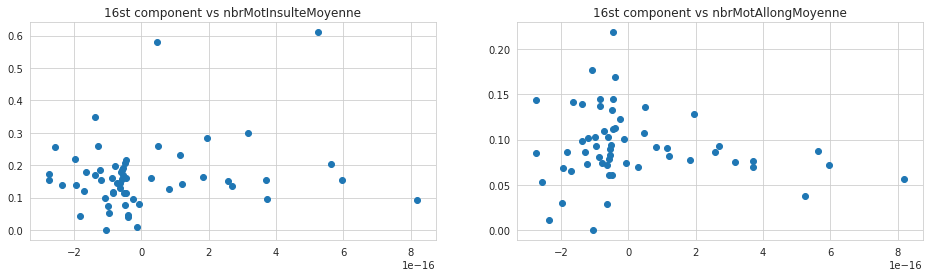

In [ ]:
#Selected variables from the correlation grahp, active variables as explained above.
act_var = [ "nbrMot", "nbrMotInsulte", "nbrMotAllong", "nbrMotMAJ", "nbrExclMark", "nbrQuestMark", "thread_count", "comment_count", "message_count", "discussion_count", "distinct_authors_count", "authors_3channels_count", "liked_authors_count","subscriberCount", "viewCount", "video_number"]
X_projec, pca = pca_process(data_channel, act_var)
cible = ['nbrMotInsulteMoyenne','nbrMotAllongMoyenne']
components_analysis(data_channel, act_var, cible)

The third component seems to be highly correlated with nbrMotAllong.
The 1st and second component are almost uncorrelated with the mean number per commentary of insult words, elongated words, capital letters word, exclamations and interrogations.

With 2 components, we have over 80 % of the variance of the dataset.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 131 missing from current font.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 131 missing from current font.



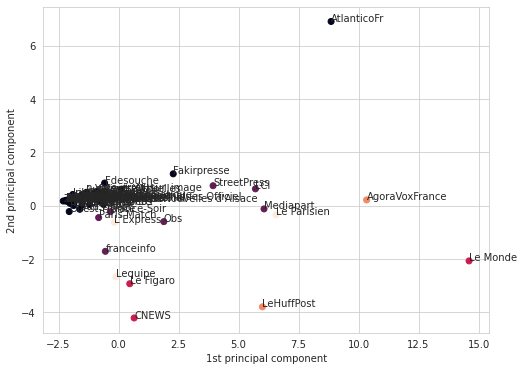

In [ ]:
plt.scatter(X_projec[:,0], X_projec[:,1],c = data_channel_indexes['Mean_shift_indexes'])
plt.xlabel('1st principal component')
plt.ylabel('2nd principal component')


for i in range(X_projec.shape[0]):
   plt.text(X_projec[i,0], X_projec[i,1], data_channel.index[i])

 It is not obvious to obtain the five clusters predicted with mean shift.

The 2 first principal components are uncorrelated with the percentage of insult words, elongated words, and capital letters words as well as their average values. Thus it is not easy to conclude about the toxicity with the pca.

# **Logistic regression - Gradient Boosting and XGBoost**

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive/")

%cd "/content/gdrive/My Drive/Colab Notebooks/Maching learning/Challenge"

# import libs
import scipy
import numpy as np
import sklearn
import pandas as pd

#importing the tool
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import pickle

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
/content/gdrive/My Drive/Colab Notebooks/Maching learning/Challenge


## k-fold Cross Validation using XGBoost

In order to build more robust models, it is common to do a k-fold cross validation where all the entries in the original training dataset are used for both training as well as validation. Also, each entry is used for validation just once. The most used set of parameters are shown next. For more information clic [here](https://xgboost.readthedocs.io/en/latest/python/python_api.html) )

* num_boost_round: denotes the number of trees you build (analogous to n_estimators)
* metrics: tells the evaluation metrics to be watched during CV
* as_pandas: to return the results in a pandas DataFrame.
* early_stopping_rounds: finishes training of the model early if the hold-out metric ("rmse" in our case) does not improve for a given number of rounds.
* seed: for reproducibility of results.

In [ ]:
 #youtube_all = pd.read_csv("data_with_cluster_indexes_Percentage.csv", encoding = "ISO-8859-1", delimiter = ";", decimal=',').dropna(axis = 1)
youtube_all = pd.read_csv("data_with_cluster_indexes_Percentage.csv", encoding = "ISO-8859-1",index_col=0)

In [ ]:
youtube_df = youtube_all.drop(columns = ["percentage_insult_words","nbrMotAllong","nbrMotMAJ"])

In [ ]:
stds = preprocessing.StandardScaler()
lab_enc = preprocessing.LabelEncoder()
# Normalization of data #
Target = youtube_df.loc[:, youtube_df.columns == 'nbrMotInsulte']# Column nbrMotInsulte
Data = youtube_df.loc[:, youtube_df.columns != 'nbrMotInsulte'].drop(columns='cluster_indexes')# all columns except nbrMotInsulte

ZData = stds.fit_transform(Data) 
ZTarget_encoded = lab_enc.fit_transform(Target.values.ravel())

In [ ]:
data_dmatrix = xgb.DMatrix(data=ZData,label=ZTarget_encoded)

In [ ]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

[22:38:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:38:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:38:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


cv_results contains train and test RMSE metrics for each boosting round.

In [ ]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,30.289584,0.509567,30.343362,1.056731
1,27.724291,0.572330,27.857080,0.842275
2,25.558895,0.575340,25.755568,0.764918
3,23.694329,0.553627,23.986309,0.744376
4,21.805338,0.470127,22.138571,0.818587


In [ ]:
print((cv_results["test-rmse-mean"]).tail(1))

49    6.355977
Name: test-rmse-mean, dtype: float64


In [ ]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

[22:38:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Visualization of Boosting Trees

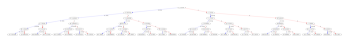

In [ ]:
import matplotlib.pyplot as plt

xgb.plot_tree(xg_reg,num_trees=3)
#plt.rcParams['figure.figsize'] = [100, 10]
plt.show()

Examine the importance of each feature column in the original dataset within the model. One way to do it is counting the number of times each feature is split on across all boosting rounds (trees) in the model, and then visualizing the result as a bar graph

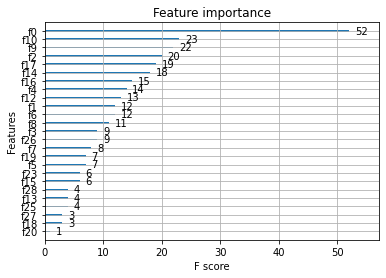

In [ ]:
xgb.plot_importance(xg_reg)
#plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [ ]:
Data.columns

Index(['nbrMot', 'nbrExclMark', 'nbrQuestMark', 'nbrMotMoyenne',
       'nbrMotInsulteMoyenne', 'nbrMotAllongMoyenne', 'nbrMotMAJMoyenne',
       'nbrExclMarkMoyenne', 'nbrQuestMarkMoyenne', 'thread_count',
       'comment_count', 'message_count', 'discussion_count',
       'distinct_authors_count', 'authors_3channels_count',
       'liked_authors_count', 'subscriberCount', 'viewCount',
       'categorie_new_Core', 'categorie_new_Niche', 'categorie_new_Partisan',
       'categ_inst_Alternatif', 'categ_inst_Presse magazine',
       'categ_inst_Presse nationale', 'categ_inst_Presse_regionale',
       'categ_inst_Pure Players', 'categ_inst_TV', 'percentage_CAPS_words',
       'percentage_elongated_words'],
      dtype='object')

In [ ]:
columnas = Data.columns.to_list()
features=[0,10,9,2,17,14,16,4,12,1,6,8]
drop_col = []
#print('drop:')
for i in [x for x in range(len(columnas)) if x not in features ]:
  drop_col.append(columnas[i])
  #print(drop)

# for i in [x for x in range(len(columnas)) if x in features ]:
#   keep=columnas[i]
#   print(keep)

## Data preparation

In [ ]:
youtube_df.columns

Index(['nbrMot', 'nbrMotInsulte', 'nbrExclMark', 'nbrQuestMark',
       'nbrMotMoyenne', 'nbrMotInsulteMoyenne', 'nbrMotAllongMoyenne',
       'nbrMotMAJMoyenne', 'nbrExclMarkMoyenne', 'nbrQuestMarkMoyenne',
       'thread_count', 'comment_count', 'message_count', 'discussion_count',
       'distinct_authors_count', 'authors_3channels_count',
       'liked_authors_count', 'subscriberCount', 'viewCount',
       'categorie_new_Core', 'categorie_new_Niche', 'categorie_new_Partisan',
       'categ_inst_Alternatif', 'categ_inst_Presse magazine',
       'categ_inst_Presse nationale', 'categ_inst_Presse_regionale',
       'categ_inst_Pure Players', 'categ_inst_TV', 'percentage_CAPS_words',
       'percentage_elongated_words', 'cluster_indexes'],
      dtype='object')

In [ ]:
youtube_df.fillna(0,inplace=True)
youtube_df.drop(columns=drop_col,inplace=True)
youtube_df.columns

Index(['nbrMot', 'nbrMotInsulte', 'nbrExclMark', 'nbrQuestMark',
       'nbrMotInsulteMoyenne', 'nbrMotMAJMoyenne', 'nbrQuestMarkMoyenne',
       'thread_count', 'comment_count', 'discussion_count',
       'authors_3channels_count', 'subscriberCount', 'viewCount',
       'cluster_indexes'],
      dtype='object')

In [ ]:
######Split columns in ratio and categorical type#####
ratio_columns = youtube_df.describe().columns
#cat_columns = youtube_df.describe(include = 'O').columns

In [ ]:
#youtube_df = pd.get_dummies(youtube_df, columns = cat_columns)
# print(youtube_df.shape, youtube_df.columns)

We isolate the target variable (Y) and the potential explanatory variables (X) in two distinct structures :

Y : A 1-d endogenous response variable. The dependent variable ;
X : A nobs x k array where nobs is the number of observations and k is the number of regressors. An intercept is not included by default and should be added by the user ;

In [ ]:
#####Standardize the data#####



ColumnsOneHot=['categorie_new_Core', 'categorie_new_Niche', 'categorie_new_Partisan',
       'categ_inst_Alternatif', 'categ_inst_Presse magazine',
       'categ_inst_Presse nationale', 'categ_inst_Presse_regionale',
       'categ_inst_Pure Players', 'categ_inst_TV','cluster_indexes']

ratio_columns=[x for x in youtube_df.columns if x not in ColumnsOneHot]
std_scale = StandardScaler().fit(youtube_df[ratio_columns])
youtube_df[ratio_columns] = std_scale.transform(youtube_df[ratio_columns])
display(youtube_df)
#print(scipy.stats.describe(Ztrain,axis=0,ddof=0))

,nbrMot,nbrMotInsulte,nbrExclMark,nbrQuestMark,nbrMotInsulteMoyenne,nbrMotMAJMoyenne,nbrQuestMarkMoyenne,thread_count,comment_count,discussion_count,authors_3channels_count,subscriberCount,viewCount,cluster_indexes
0,0.309899,0.139278,0.474081,0.674523,-0.104237,0.182164,0.210511,0.193979,0.422968,1.172706,0.577726,1.404212,1.959844,3
1,-0.183536,-0.120394,-0.180945,-0.197541,1.074581,-0.080324,-0.290564,-0.163651,-0.196578,-0.257428,-0.240045,0.149466,0.583856,1
2,0.308726,0.950755,0.440915,0.587317,0.683195,-0.057056,0.121189,0.253583,0.461212,0.866248,0.613281,1.404212,1.959844,3
3,-0.186665,-0.152853,-0.180945,-0.197541,-0.425732,0.133744,-0.290564,-0.172166,-0.196578,-0.257428,-0.257823,-1.416208,-1.328806,0
4,-0.091107,-0.104165,-0.139488,-0.110335,-0.132193,0.063939,-0.016062,-0.044441,-0.150686,-0.053124,-0.133379,-1.189041,-1.266406,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46097,-0.185101,-0.152853,-0.156071,-0.197541,-0.425732,-0.187358,-0.290564,-0.163651,-0.196578,-0.257428,-0.240045,-0.193217,-0.103485,2
46098,-0.157463,-0.136624,-0.180945,-0.183007,1.824738,-0.187358,0.761693,-0.180681,-0.196578,-0.257428,-0.257823,3.317849,0.619922,1
46099,-0.149772,-0.120394,-0.164362,-0.197541,0.136885,-0.066945,-0.290564,-0.121076,-0.196578,-0.257428,-0.168934,0.149466,0.583856,1
46100,-0.164242,-0.152853,-0.131196,-0.153938,-0.425732,-0.187358,0.761693,-0.172166,-0.188930,-0.206352,-0.257823,0.067479,0.702024,1


In [ ]:
# spliting data into train/test
train=youtube_df.sample(frac=0.85,random_state=123) #must set a seed value in random_state option 
test=youtube_df.drop(train.index)

In [ ]:
## For Prediction
# for train dataset
Ytrain = train.loc[:, train.columns == 'nbrMotInsulte'] # Column nbrMotInsulte
Xtrain = train.loc[:, train.columns != 'nbrMotInsulte']# all columns except nbrMotInsulte
#============================================================
# and the same with test data

Ytest = test.loc[:, test.columns == 'nbrMotInsulte'] # Column nbrMotInsulte
Xtest = test.loc[:, test.columns != 'nbrMotInsulte']# all columns except nbrMotInsulte

## For Classification

# for train dataset
Ytrainc = train.loc[:, train.columns == 'cluster_indexes'] # Column nbrMotInsulte
Xtrainc = train.loc[:, train.columns != 'cluster_indexes']# all columns except nbrMotInsulte
#============================================================
# and the same with test data

Ytestc = test.loc[:, test.columns == 'cluster_indexes'] # Column nbrMotInsulte
Xtestc = test.loc[:, test.columns != 'cluster_indexes']# all columns except nbrMotInsulte


Codification of the target values

In [ ]:
lab_enc = preprocessing.LabelEncoder()
Ytrain_encoded = lab_enc.fit_transform(Ytrain.values.ravel())
Ytest_encoded = lab_enc.fit_transform(Ytest.values.ravel())

Taking into account that the different methods analyzed in this Challenge have several hyper parameters, in order to estimate the best combination of them, we use the GridSearchCV library (for more information [here](https://https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)), which performs exhaustive search over specified parameter values for an estimator.

## Logistic regression

Logistic regression is a classification algorithm used to assign observations to a discrete set of classes, i.e., values between {0.1} or {0.1,2,3,...}.For the implementation we use the sklearn library ( more information click [here](https://https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) ). In this Challenge this algorithm is used to predict a continuous variable as well as  a category variable

### Logistic for prediction of 'nbrMotInsulte'

For the first experiment it tries to make the prediction of the variable "nbrMotInsulte" by categorizing the different numbers it takes. 

In [ ]:
Xtrain_L=Xtrain.drop(columns=['cluster_indexes'])
Xtest_L=Xtest.drop(columns=['cluster_indexes'])
Ytrain_L=Ytrain.copy()
Ytest_L=Ytest.copy()
Ytrain_encoded_L=Ytrain_encoded.copy()
Ytest_encoded_L=Ytest_encoded.copy()

In [ ]:
# from sklearn.linear_model import LogisticRegression

# parameters = {'penalty':['l2','none'],'max_iter': [100,1000],'solver':['saga','lbfgs']}
# model = LogisticRegression()


# gridGL = GridSearchCV(model,parameters)
# gridGL.fit(Xtrain_L, Ytrain_encoded_L)

# filename = 'finalized_model_LRpred.sav'
# pickle.dump(gridGL, open(filename, 'wb'))


Test of the performance of the logistic prediction

In [ ]:
import sklearn.metrics as metrics 

filename = 'finalized_model_LRpred.sav'
gridGL = pickle.load(open(filename, 'rb'))

print("r2 / variance : ", gridGL.best_score_)
print("Best params : ", gridGL.best_params_)

predGL=gridGL.predict(Xtest_L)

print('Mean Absolute Error:', metrics.mean_absolute_error(Ytest_encoded_L, predGL))
print('Mean Squared Error:', metrics.mean_squared_error(Ytest_encoded_L, predGL))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Ytest_encoded_L, predGL)))


r2 / variance :  0.6581009281252757
Best params :  {'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Mean Absolute Error: 3.9357917570498917
Mean Squared Error: 245.86579898770788
Root Mean Squared Error: 15.680108385713023


### Logistic for classification

For the this experiment we perform the classification of the toxic variable

In [ ]:
# from sklearn.linear_model import LogisticRegression

# parameters = {'penalty':['l2'],'max_iter': [100],'solver':['saga','lbfgs']}
# model = LogisticRegression()


# gridGLc = GridSearchCV(model,parameters)
# gridGLc.fit(Xtrainc, Ytrainc.values.ravel())

# filename = 'finalized_model_LRc.sav'
# pickle.dump(gridGLc, open(filename, 'wb'))

In [ ]:
import sklearn.metrics as metrics 

filename = 'finalized_model_LRc.sav'
predLRc = pickle.load(open(filename, 'rb'))

print("r2 / variance : ", gridGLc.best_score_)
print("Best params : ", gridGLc.best_params_)

predLRc=gridGLc.predict(Xtestc)

print('Accuracy:', metrics.accuracy_score(Ytestc, predLRc))
print('F1 score:', metrics.f1_score(Ytestc,predLRc, average='macro'))


r2 / variance :  0.9999489633171766
Best params :  {'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy: 1.0
F1 score: 1.0


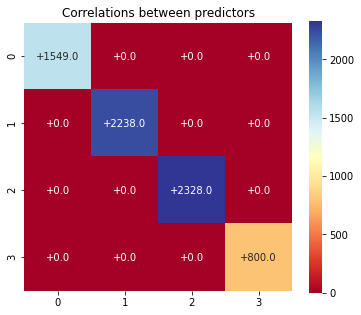

In [ ]:
import seaborn as sns

# Confusion matrix
corr = metrics.confusion_matrix(Ytestc, predLRc)
plt.figure(figsize=(6,5))
sns.heatmap(corr, cmap="RdYlBu", annot=True, square=True, vmin=-0.8, vmax=corr.max() + 0.8, fmt="+.1f")
plt.title("Correlations between predictors")
plt.show()

## Gradient Boosting 
Is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, make the ensemble of weak prediction models, mainly union of decision trees. In this section we will use the model for the prediction of a continuous variable as well as for a classification

### Gradient Boosting for regression

Gradient Boots for regression provides different typer of parameters for tuning. In this implementation are used some of them. For more information clic [here](https://https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html)



*   n_estimators: the number of boosting stages to be performed by the model. In other words number of estimators denotes the number of trees in the forest
*   max_depth: is the depth of the decision tree estimator in the gradient boosting regressor
* learning_rate: is a hyper-parameter in gradient boosting regressor algorithm that determines the step size at each iteration while moving toward a minimum of a loss function.
* criterion: is used to measure the quality of a split for decision tree




In [ ]:
# from sklearn.ensemble import GradientBoostingRegressor
# parameters = {'learning_rate' :[0.01,0.1,0.5],'max_depth': [5,7,10], 'n_estimators': [10,20,40],'criterion':['mse']}
# model = GradientBoostingRegressor()

# gridGB = GridSearchCV(model,parameters)
# gridGB.fit(Xtrain_L, Ytrain_encoded_L)

# filename = 'finalized_model_GB.sav'
# pickle.dump(gridGB, open(filename, 'wb'))

Taking into account the best set of parameters found, the model is evaluated:

In [ ]:
import sklearn.metrics as metrics 

filename = 'finalized_model_GBoost.sav'
predGB = pickle.load(open(filename, 'rb'))

print("r2 / variance : ", grid.best_score_)
print("Best params : ", grid.best_params_)

predGB=gridGB.predict(Xtest_L)

print('Mean Absolute Error:', metrics.mean_absolute_error(Ytest_encoded_L, predGB))
print('Mean Squared Error:', metrics.mean_squared_error(Ytest_encoded_L, predGB))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Ytest_encoded_L, predGB)))

r2 / variance :  0.9765354154757769
Best params :  {'learning_rate': 0.5, 'max_depth': 7, 'n_estimators': 15}
MSE: 11.433987
Mean Absolute Error: 1.8562000024196508
Mean Squared Error: 130.73606742907577
Root Mean Squared Error: 11.43398738100912


### Gradient Boosting for classification
Gradient Boots for regression provides different typer of parameters for tuning. In this implementation are used some of them. For more information clic [here](https://https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

* loss: loss function to be optimized. ‘deviance’ refers to deviance (= logistic regression) for classification with probabilistic outputs 
* learning_rate: learning rate shrinks the contribution of each tree by learning_rate
* n_estimators: The number of boosting stages to perform.

In [ ]:
# from sklearn.ensemble import GradientBoostingClassifier

# parametersc = {'learning_rate' :[0.01,0.1,0.5],'max_depth': [5,7,10], 'n_estimators': [10,20,40],'criterion':['mse']}
# modelc = GradientBoostingClassifier()

# gridGBc = GridSearchCV(modelc,parametersc)
# gridGBc.fit(Xtrainc, Ytrainc.values.ravel())

# filename = 'finalized_model_GBc.sav'
# pickle.dump(gridGBc, open(filename, 'wb'))

Taking into account the best set of parameters found, the model is evaluated:


In [ ]:
import sklearn.metrics as metrics 

filename = 'finalized_model_GBc.sav'
gridGBc = pickle.load(open(filename, 'rb'))

print("r2 / variance : ", gridGBc.best_score_)
print("Best params : ", gridGBc.best_params_)


predGBc=gridGBc.predict(Xtestc)

print('Accuracy:', metrics.accuracy_score(Ytestc, predGBc))
print('F1 score:', metrics.f1_score(Ytestc, predGBc, average='macro'))
#print('Average_precision:', metrics.average_precision_score(Ytestc, predGBc))

r2 / variance :  1.0
Best params :  {'criterion': 'mse', 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 40}
Accuracy: 1.0
F1 score: 1.0


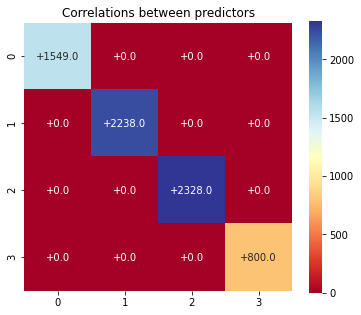

In [ ]:
import seaborn as sns

# Confusion matrix
corr = metrics.confusion_matrix(Ytestc, predGBc)
plt.figure(figsize=(6,5))
sns.heatmap(corr, cmap="RdYlBu", annot=True, square=True, vmin=-0.8, vmax=corr.max() + 0.8, fmt="+.1f")
plt.title("Correlations between predictors")
plt.show()

## XGBoost
In this section is applied the XGBoost that is an optimized implementation of Gradient Boosting

XGBoots provides different typer of parameters for tuning. In this implementation are used some of them. For more information clic [here](https://xgboost.readthedocs.io/en/latest/parameter.html#general-parameters)

* learning_rate: step size shrinkage used to prevent overfitting. Range is [0,1]
* max_depth: determines how deeply each tree is allowed to grow during any boosting round.
* subsample: percentage of samples used per tree. Low value can lead to underfitting.
* colsample_bytree: percentage of features used per tree. High value can lead to overfitting.
* n_estimators: number of trees you want to build.
* objective: determines the loss function to be used like reg:linear for regression problems, reg:logistic for classification problems with only decision, binary:logistic for classification problems with probability.

### XGBoost for regression

In this section the algorithm is used to predict the variable 'nbrMotInsulte'

In the next code is instantiated an XGBoost regressor object with the hyper-parameters passed as arguments.

In [ ]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 7, alpha = 0.9, n_estimators = 15)

xg_reg.fit(Xtrain_L,Ytrain_encoded_L) #Fit the regressor to the training set

[19:51:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(alpha=0.9, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=None, n_estimators=15,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

The model is evaluated :

In [ ]:
predXG = xg_reg.predict(Xtest_L)

print('Mean Absolute Error:', metrics.mean_absolute_error(Ytest_encoded_L, predXG))
print('Mean Squared Error:', metrics.mean_squared_error(Ytest_encoded_L, predXG))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Ytest_encoded_L, predXG)))

Mean Absolute Error: 2.7020178162310318
Mean Squared Error: 63.78509330284241
Root Mean Squared Error: 7.986557036849009


### XGBoost for classification

In this section the algorithm is used to make the classification

In [ ]:
xg_regc = xgb.XGBClassifier(random_state=1,learning_rate=0.01)
xg_regc.fit(Xtrainc,Ytrainc) #Fit the regressor to the training set

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

The model is evaluated :

In [ ]:
predXGc = xg_regc.predict(Xtestc)

print('Accuracy:', metrics.accuracy_score(Ytestc, predGBc))
print('F1 score:', metrics.f1_score(Ytestc, predGBc, average='macro'))

Accuracy: 1.0
F1 score: 1.0


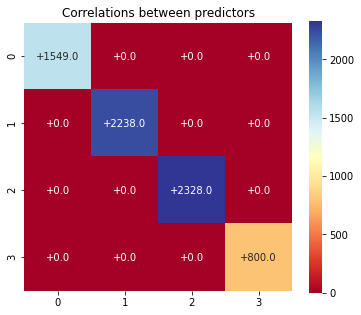

In [ ]:
import seaborn as sns

# Confusion matrix
corr = metrics.confusion_matrix(Ytestc, predXGc)
plt.figure(figsize=(6,5))
sns.heatmap(corr, cmap="RdYlBu", annot=True, square=True, vmin=-0.8, vmax=corr.max() + 0.8, fmt="+.1f")
plt.title("Correlations between predictors")
plt.show()

# **K-Nearest Neighbors - Tree and Random forest**

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive/")

%cd "/content/gdrive/My Drive/IMT Atlantique/Machine Learning/Supervised_Challenge"

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
/content/gdrive/My Drive/IMT Atlantique/Machine Learning/Supervised_Challenge


In [ ]:
# Libraries
from sklearn import datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
import pickle
from sklearn import metrics

In [ ]:
## Data preparation

#youtube_all = pd.read_csv("data_with_cluster_indexes_Percentage.csv", encoding = "ISO-8859-1", delimiter = ";", decimal=',').dropna(axis = 1)
youtube_all = pd.read_csv("data_with_cluster_indexes.csv", encoding = "ISO-8859-1",index_col=0)

Labels = youtube_all['cluster_indexes']
youtube_df = youtube_all.drop(columns = ["percentage_insult_words","nbrMotAllong","nbrMotMAJ", 'nbrMotMoyenne', 'nbrMotAllongMoyenne', 'nbrExclMarkMoyenne', 'message_count',
'distinct_authors_count', 'liked_authors_count', 'categorie_new_Core', 'categorie_new_Niche', 'categorie_new_Partisan', 'categ_inst_Alternatif', 'categ_inst_Presse magazine',
'categ_inst_Presse nationale', 'categ_inst_Presse_regionale', 'categ_inst_Pure Players', 'categ_inst_TV', 'percentage_CAPS_words' , 'percentage_elongated_words', 'cluster_indexes'])

######Split columns in ratio and categorical type#####
ratio_columns = youtube_df.describe().columns
#cat_columns = youtube_df.describe(include = 'O').columns

#youtube_df = pd.get_dummies(youtube_df, columns = cat_columns)
print(youtube_df.shape, youtube_df.columns.to_list())




(46102, 13) ['nbrMot', 'nbrMotInsulte', 'nbrExclMark', 'nbrQuestMark', 'nbrMotInsulteMoyenne', 'nbrMotMAJMoyenne', 'nbrQuestMarkMoyenne', 'thread_count', 'comment_count', 'discussion_count', 'authors_3channels_count', 'subscriberCount', 'viewCount']


We isolate the target variable (Y) and the potential explanatory variables (X) in two distinct structures :

Y : A 1-d endogenous response variable. The dependent variable ;
X : A nobs x k array where nobs is the number of observations and k is the number of regressors. An intercept is not included by default and should be added by the user .


In [ ]:


#####Standardize the data#####
#instanciation
from sklearn.preprocessing import StandardScaler

# stds = preprocessing.StandardScaler()

# #transformation
# Ztrain = stds.fit_transform(Xtrain) #PCA
# Ztest = stds.fit_transform(Xtest) #PCA
# Wtrain = stds.fit_transform(Ytrain) #PCA
# Wtest = stds.fit_transform(Ytest) #PCA
ColumnsOneHot=['categorie_new_Core', 'categorie_new_Niche', 'categorie_new_Partisan',
       'categ_inst_Alternatif', 'categ_inst_Presse magazine',
       'categ_inst_Presse nationale', 'categ_inst_Presse_regionale',
       'categ_inst_Pure Players', 'categ_inst_TV','cluster_indexes']

ratio_columns=[x for x in youtube_df.columns if x not in ColumnsOneHot]
std_scale = StandardScaler().fit(youtube_df[ratio_columns])
youtube_df[ratio_columns] = std_scale.transform(youtube_df[ratio_columns])
display(youtube_df)
#print(scipy.stats.describe(Ztrain,axis=0,ddof=0))

type(youtube_all)

# spliting data into train/test
train=youtube_df.sample(frac=0.85,random_state=123) #must set a seed value in random_state option 
test=youtube_df.drop(train.index)

#===========================================================
# for train dataset
Ytrain = train.loc[:, train.columns == 'nbrMotInsulte'] # Column nbrMotInsulte
Xtrain = train.loc[:, train.columns != 'nbrMotInsulte']# all columns except nbrMotInsulte
#============================================================
# and the same with test data

Ytest = test.loc[:, test.columns == 'nbrMotInsulte'] # Column nbrMotInsulte
Xtest = test.loc[:, test.columns != 'nbrMotInsulte']# all columns except nbrMotInsulte


,nbrMot,nbrMotInsulte,nbrExclMark,nbrQuestMark,nbrMotInsulteMoyenne,nbrMotMAJMoyenne,nbrQuestMarkMoyenne,thread_count,comment_count,discussion_count,authors_3channels_count,subscriberCount,viewCount
0,0.309899,0.139278,0.474081,0.674523,-0.104237,0.182164,0.210511,0.193979,0.422968,1.172706,0.577726,1.404212,1.959844
1,-0.183536,-0.120394,-0.180945,-0.197541,1.074581,-0.080324,-0.290564,-0.163651,-0.196578,-0.257428,-0.240045,0.149466,0.583856
2,0.308726,0.950755,0.440915,0.587317,0.683195,-0.057056,0.121189,0.253583,0.461212,0.866248,0.613281,1.404212,1.959844
3,-0.186665,-0.152853,-0.180945,-0.197541,-0.425732,0.133744,-0.290564,-0.172166,-0.196578,-0.257428,-0.257823,-1.416208,-1.328806
4,-0.091107,-0.104165,-0.139488,-0.110335,-0.132193,0.063939,-0.016062,-0.044441,-0.150686,-0.053124,-0.133379,-1.189041,-1.266406
...,...,...,...,...,...,...,...,...,...,...,...,...,...
46097,-0.185101,-0.152853,-0.156071,-0.197541,-0.425732,-0.187358,-0.290564,-0.163651,-0.196578,-0.257428,-0.240045,-0.193217,-0.103485
46098,-0.157463,-0.136624,-0.180945,-0.183007,1.824738,-0.187358,0.761693,-0.180681,-0.196578,-0.257428,-0.257823,3.317849,0.619922
46099,-0.149772,-0.120394,-0.164362,-0.197541,0.136885,-0.066945,-0.290564,-0.121076,-0.196578,-0.257428,-0.168934,0.149466,0.583856
46100,-0.164242,-0.152853,-0.131196,-0.153938,-0.425732,-0.187358,0.761693,-0.172166,-0.188930,-0.206352,-0.257823,0.067479,0.702024


Codification of the target values


In [ ]:
####Codification

# lab_enc = preprocessing.LabelEncoder()
# Ytrain_encoded = lab_enc.fit_transform(Wtrain.values.ravel())
# Ytest_encoded = lab_enc.fit_transform(Wtest.values.ravel())

## K-Nearest Neighbors Algorithm

Preprocessing – Scaling the features

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

x_train_scaled = scaler.fit_transform(Xtrain)
Xtrain = pd.DataFrame(x_train_scaled)

x_test_scaled = scaler.fit_transform(Xtest)
Xtest = pd.DataFrame(x_test_scaled)

Here we have a look at the error rate for different k values

In [ ]:
#import required packages
from sklearn import neighbors
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Select an algorithm
model = neighbors.KNeighborsRegressor()

We will adopt the approach of k-fold cross-validation. In this example, I use 3 folds :

In [ ]:
# Create 3 folds
seed = 13
kfold = KFold(n_splits=3, shuffle=True, random_state=seed)

Now we can create a set of candidate hyperparameters that we want to examine:

In [ ]:
# Define our candidate hyperparameters
k_neighbours = list(range(2,25))
hp_candidates = [{'n_neighbors': k_neighbours, 'weights': ['uniform','distance']}]

We pass this algorithm and set of hyperparameters to the GridSearchCV() function, asking it to use the mean square error (mse) to evaluate the models it creates. We fit each model it creates using the training data:

In [ ]:
# Search for best hyperparameters
grid = GridSearchCV(estimator=model, param_grid=hp_candidates, cv=kfold, scoring='neg_mean_squared_error')
grid.fit(Xtrain, Ytrain)

GridSearchCV(cv=KFold(n_splits=3, random_state=13, shuffle=True),
             error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=20, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14, 15, 16, 17, 18, 19, 20, 21,
                                          22, 23, 24],
                          'weights': ['uniform', 'distance']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

We can inspect the grid and see which combination of model hyperparameters gave us the best mse value:

In [ ]:
# Get the results
print(abs(grid.best_score_))
print(grid.best_estimator_)
print(grid.best_params_)

0.12168865973908229
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                    weights='distance')
{'n_neighbors': 4, 'weights': 'distance'}


GridSearchCV() has determined that n_neighbors=4 and weights=distance is the best set of hyperparameters to use for this data. Using this set of hyperparameters, we get an evaluation score of 0.1216.

We can get a full breakdown of what GridSearchCV() has done by:

In [ ]:
grid.cv_results_

{'mean_fit_time': array([0.24293605, 0.24616893, 0.25556382, 0.25108488, 0.26160383,
        0.25440129, 0.2504429 , 0.25498931, 0.25021052, 0.25567357,
        0.25977516, 0.25414443, 0.25701968, 0.25741084, 0.25302037,
        0.25021132, 0.24919701, 0.25257397, 0.25961105, 0.24955146,
        0.25497588, 0.25110809, 0.25044537, 0.2597084 , 0.25584555,
        0.25101519, 0.25873701, 0.25887442, 0.25894562, 0.25484633,
        0.25169317, 0.24878343, 0.24941667, 0.25043201, 0.25240699,
        0.25566816, 0.26406558, 0.25217962, 0.2550137 , 0.25070071,
        0.25855835, 0.25421842, 0.25325052, 0.25573921, 0.25415699,
        0.25256681]),
 'mean_score_time': array([0.47827601, 0.4770453 , 0.50388932, 0.51925715, 0.53419646,
        0.54333003, 0.56628839, 0.55672288, 0.57395808, 0.57968553,
        0.59442282, 0.59418257, 0.61352285, 0.60010513, 0.61422284,
        0.61496941, 0.62957486, 0.63173787, 0.64163017, 0.64663792,
        0.6534152 , 0.65483832, 0.66120068, 0.65710394, 0.

In [ ]:
rmse_val = [] #to store rmse values for different k
mse_val = []

modelf = neighbors.KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                    weights='distance')

modelf.fit(Xtrain, Ytrain)  #fit the model
pred=modelf.predict(Xtest) #make prediction on test set

# save the model to disk
filenameKnnR = 'finalized_model_KNNRegressor.sav'
pickle.dump(modelf, open(filenameKnnR, 'wb'))


In [ ]:
# load the model from disk
loaded_model = pickle.load(open(filenameKnnR, 'rb'))
predKnn = loaded_model.score(Xtest)
print(predKnn)

Here we evaluate the metrics of Mean Absolute Error , Mean Squared Error and Root Mean Squared Error in the model found before, in order to compare with the other algorithms.

In [ ]:
from sklearn import metrics

def metrics (Ytest, prediction):
  print('Mean Absolute Error:', metrics.mean_absolute_error(Ytest, prediction))
  print('Mean Squared Error:', metrics.mean_squared_error(Ytest, prediction))
  print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Ytest, prediction)))


In [ ]:
metrics(Ytest, pred)

Mean Absolute Error: 0.09261176165605471
Mean Squared Error: 1.0298869741658017
Root Mean Squared Error: 1.014833471149726


## Regression Decision Tree and Random forest

Regression Decision Tree

In [ ]:
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor

In [ ]:

modelTree = tree.DecisionTreeRegressor()
modelTree


DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [ ]:
# Define our candidate hyperparameters
hp_candidates = [{'n_estimators' : [40, 60, 80,100], 'splitter' : ['best', 'random'],
                  'max_depth' : [2, 3, 4, 5, 6, 7, 8, 9, 10]}]

In [ ]:
# Search for best hyperparameters
gridTree = GridSearchCV(estimator=modelTree, param_grid=hp_candidates, cv=kfold, scoring='neg_mean_squared_error')
gridTree.fit(Xtrain, Ytrain)

GridSearchCV(cv=KFold(n_splits=3, random_state=13, shuffle=True),
             error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'criterion': ['mse', 'friedman_mse', 'mae'],
                        

We can inspect the grid and see which combination of model hyperparameters gave us the best mse value:

In [ ]:
# Get the results
print(abs(gridTree.best_score_))
print(gridTree.best_estimator_)
print(gridTree.best_params_)

0.106190030338698
DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=10,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='random')
{'criterion': 'mse', 'max_depth': 10, 'splitter': 'random'}


GridSearchCV() has determined that criterion ='mse, max_depth=10 and splitter=random is the best set of hyperparameters to use for this data. Using this set of hyperparameters, we get an evaluation score of 0.1061.

In [ ]:
modelTreef = DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=10,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='random')

modelTreef.fit(Xtrain, Ytrain)  #fit the model
predTree=modelTreef.predict(Xtest) #make prediction on test set

# save the model to disk
filenameTreeR = 'finalized_model_TreeRegressor.sav'
pickle.dump(modelTreef, open(filenameTreeR, 'wb'))

In [ ]:
# load the model from disk
loaded_model = pickle.load(open(filenameTreeR, 'rb'))
predTree = loaded_model.score(Xtest)
print(predTree)

Here we evaluate the metrics of Mean Absolute Error , Mean Squared Error and Root Mean Squared Error in the model found before, in order to compare with the other algorithms.

In [ ]:
from sklearn import metrics
#pred = modelForest.predict(Xtest)

print('Mean Absolute Error:', metrics.mean_absolute_error(Ytest, predTree))
print('Mean Squared Error:', metrics.mean_squared_error(Ytest, predTree))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Ytest, predTree)))

Mean Absolute Error: 1.4456327127216317
Mean Squared Error: 3.2262067261633423
Root Mean Squared Error: 1.7961644485300732


## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

modelForest = RandomForestRegressor( n_estimators=100)
#regressor.fit(train_X, train_Y)
modelForest

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

We can observe the metrics that we apply to evaluate the algorithms.

In [ ]:
modelForest.fit(Xtrain,np.ravel(Ytrain))

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
from sklearn import metrics
pred = modelForest.predict(Xtest)

print('Mean Absolute Error:', metrics.mean_absolute_error(Ytest, pred))
print('Mean Squared Error:', metrics.mean_squared_error(Ytest, pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Ytest, pred)))

Mean Absolute Error: 0.02689209121852358
Mean Squared Error: 0.738542161668966
Root Mean Squared Error: 0.8593847576429117


GridSearchCV() has determined that criterion ='mse, max_depth=10 and splitter=random is the best set of hyperparameters to use for this data. Using this set of hyperparameters, we get an evaluation score of 0.1061.

In [ ]:
# load the model from disk
loaded_model = pickle.load(open(filenameForestR, 'rb'))
predForest = loaded_model.score(Xtest)
print(predForest)

FileNotFoundError: ignored

Here we evaluate the metrics of Mean Absolute Error , Mean Squared Error and Root Mean Squared Error in the model found before, in order to compare with the other algorithms.

## Data Split for Classification

In [ ]:
###Data Split Classifiers

# # spliting data into train/test
youtube_df['cluster_indexes'] = Labels
youtube_df.drop(columns = ['nbrMotInsulte'])
train=youtube_df.sample(frac=0.85,random_state=123) #must set a seed value in random_state option 
test=youtube_df.drop(train.index)


#===========================================================
# for train dataset
Ytrain = train.loc[:, train.columns == 'cluster_indexes'] # Column nbrMotInsulte
Xtrain = train.loc[:, train.columns != 'cluster_indexes']# all columns except nbrMotInsulte
#============================================================
# and the same with test data

Ytest = test.loc[:, test.columns == 'cluster_indexes'] # Column nbrMotInsulte
Xtest = test.loc[:, test.columns != 'cluster_indexes']# all columns except nbrMotInsulte


## K-Nearest Neighbors Algorithm - Classifier

In [ ]:
''' Importan function to metrics evaluation '''
def metrics_evaluation_classification(model, X_test, y_test, to_tensor = False):
    if to_tensor:
        X_test = torch.from_numpy(X_test.values).float()
        X_test = X_test.to(device, dtype=torch.float32)
        with torch.no_grad():
            y_pred = model.forward(X_test)
        
        y_pred = y_pred.to("cpu").numpy()
        
        # Softmax
        y_pred = np.exp(y_pred)
        y_pred /= 4*np.expand_dims(np.mean(y_pred, axis = 1), axis = 1)
        y_pred = np.argmax(y_pred, axis = 1)
    else:
        y_pred = model.predict(X_test)
    
    print('Accuracy:', metrics.accuracy_score(y_test, y_pred)) # Model Accuracy, how often is the classifier correct?
    print('F1 score:', metrics.f1_score(y_test, y_pred, average='macro'))
    
    # Confusion matrix
    corr = metrics.confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(corr, cmap="RdYlBu", annot=True, square=True, vmin=-0.8, vmax=corr.max() + 0.8, fmt="+.1f")
    plt.title("Correlations between predictors")
    plt.show()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

modelKnnClas = KNeighborsClassifier(n_neighbors=4)


# Train the model using the training sets
modelKnnClas.fit(Xtrain, np.ravel(Ytrain))

#Predict Output
predicted= modelKnnClas.predict(Xtest) # 0:Overcast, 2:Mild
print(predicted)

from sklearn import metrics

print("Accuracy:",metrics.accuracy_score(Ytest, predicted))

[1 2 1 ... 0 1 1]
Accuracy: 0.9908893709327549


Accuracy: 0.9908893709327549
F1 score: 0.9911142904237694


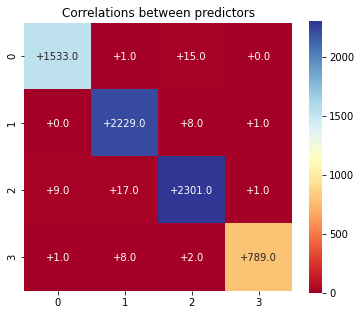

In [ ]:
metrics_evaluation_classification(modelKnnClas, Xtest, Ytest, to_tensor= False)

## Decision Tree and Random forest Classifiers

Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# Create Decision Tree classifer object
modelTreeC = DecisionTreeClassifier(criterion="entropy", max_depth=3)

# Train Decision Tree Classifer
modelTreeC = modelTreeC.fit(Xtrain, Ytrain)

#Predict the response for test dataset
predTreeC = modelTreeC.predict(Xtest)

Accuracy: 1.0
F1 score: 1.0


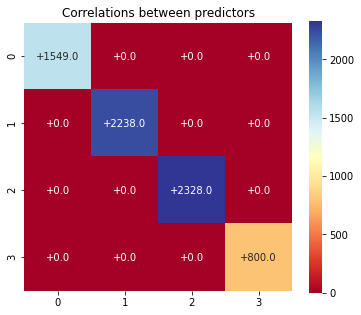

In [ ]:
metrics_evaluation_classification(modelTreeC, Xtest, Ytest, to_tensor= False)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


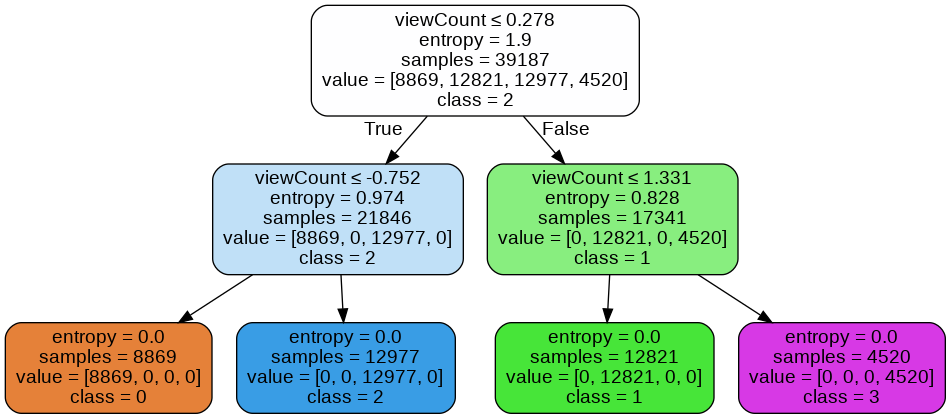

In [ ]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
feature_cols = youtube_df.drop(columns = ['cluster_indexes'], inplace = True)
feature_cols = youtube_df.columns.to_list()

export_graphviz(modelTreeC, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['0','1','2','3'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('videotree.png')
Image(graph.create_png())

In the previous image you can see that there is a total of 39187 samples, where class 1 and 2 have most of these with 12821 and 12977 respectively, so class 2 is the node sheet, because it has more samples, in the second level you can see that class 1 and 2 predominates taking into account the number of video views, in the 3 level you can see the 4 classes with entropy 0 which means that all the samples are homogeneous and belong to the same class.

Random Forest Classifier

In [ ]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier
import numpy as np

#Create a Gaussian Classifier
modelForestC=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
modelForestC.fit(Xtrain, np.ravel(Ytrain))

predForest=modelForestC.predict(Xtest)



Accuracy: 1.0
F1 score: 1.0


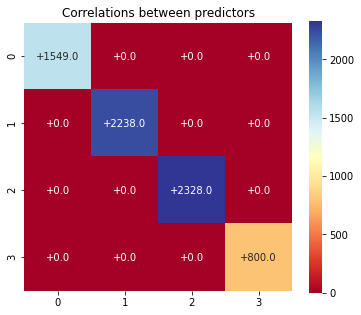

In [ ]:
metrics_evaluation_classification(modelTreeC, Xtest, Ytest, to_tensor= False)

# **Support Vector Regression and Neuronal Networks**

In [ ]:
# Libraries
import time, os, sys, copy, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib # library to save skelearn models

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torchvision
from torchsummary import summary

# For colab
IN_COLAB = 'google.colab' in sys.modules
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/gdrive')
    %cd "/content/gdrive/My Drive/Colab Notebooks/Challenge 2 (supervided)"

# Others
from IPython.display import clear_output

In [ ]:
# youtube_all = pd.read_csv("challenge_youtube_toxic.csv", encoding = "ISO-8859-1", delimiter = ";", decimal=',').dropna(axis = 1)
youtube_all = pd.read_csv("data_with_cluster_indexes.csv", encoding = "ISO-8859-1", index_col = 0)
display(youtube_all.head().append(youtube_all.tail()))
print(youtube_all.shape, youtube_all.columns)

,nbrMot,nbrMotInsulte,nbrMotAllong,nbrMotMAJ,nbrExclMark,nbrQuestMark,nbrMotMoyenne,nbrMotInsulteMoyenne,nbrMotAllongMoyenne,nbrMotMAJMoyenne,...,categ_inst_Alternatif,categ_inst_Presse magazine,categ_inst_Presse nationale,categ_inst_Presse_regionale,categ_inst_Pure Players,categ_inst_TV,percentage_insult_words,percentage_CAPS_words,percentage_elongated_words,cluster_indexes
0,3813,18,4,145,79,60,30.261900,0.142857,0.031746,1.150794,...,0,0,0,0,1,0,0.472069,3.802780,0.104904,3
1,28,2,0,1,0,0,9.333333,0.666667,0.000000,0.333333,...,0,0,0,0,0,1,7.142857,3.571429,0.000000,1
2,3804,68,9,56,75,54,27.565220,0.492754,0.065217,0.405797,...,0,0,0,0,1,0,1.787592,1.472135,0.236593,3
3,4,0,1,2,0,0,2.000000,0.000000,0.500000,1.000000,...,0,0,0,1,0,0,0.000000,50.000000,25.000000,0
4,737,3,1,18,5,6,32.043478,0.130435,0.043478,0.782609,...,0,0,1,0,0,0,0.407056,2.442334,0.135685,0
46097,16,0,0,0,3,0,5.333333,0.000000,0.000000,0.000000,...,0,0,0,1,0,0,0.000000,0.000000,0.000000,2
46098,228,1,1,0,0,1,228.000000,1.000000,1.000000,0.000000,...,0,0,1,0,0,0,0.438596,0.000000,0.438596,1
46099,287,2,0,3,2,0,35.875000,0.250000,0.000000,0.375000,...,0,0,0,0,0,1,0.696864,1.045296,0.000000,1
46100,176,0,0,0,6,3,58.666670,0.000000,0.000000,0.000000,...,0,0,1,0,0,0,0.000000,0.000000,0.000000,1
46101,16608,152,66,335,177,179,22.504070,0.205962,0.089431,0.453929,...,0,0,0,0,1,0,0.915222,2.017100,0.397399,3


(46102, 34) Index(['nbrMot', 'nbrMotInsulte', 'nbrMotAllong', 'nbrMotMAJ', 'nbrExclMark',
       'nbrQuestMark', 'nbrMotMoyenne', 'nbrMotInsulteMoyenne',
       'nbrMotAllongMoyenne', 'nbrMotMAJMoyenne', 'nbrExclMarkMoyenne',
       'nbrQuestMarkMoyenne', 'thread_count', 'comment_count', 'message_count',
       'discussion_count', 'distinct_authors_count', 'authors_3channels_count',
       'liked_authors_count', 'subscriberCount', 'viewCount',
       'categorie_new_Core', 'categorie_new_Niche', 'categorie_new_Partisan',
       'categ_inst_Alternatif', 'categ_inst_Presse magazine',
       'categ_inst_Presse nationale', 'categ_inst_Presse_regionale',
       'categ_inst_Pure Players', 'categ_inst_TV', 'percentage_insult_words',
       'percentage_CAPS_words', 'percentage_elongated_words',
       'cluster_indexes'],
      dtype='object')


For the analysis of the process, we have decided to remove the variables corresponding to the identifier of each observation. Additionally, the identifier has been removed from the communication channel, in order to seek impartiality in the analysis and not to fall into favoritism (being possible to extrapolate the results to other media). And finally, we keep only the variables that XGBoost algorithm considerer (up for 13).

In [ ]:
# youtube_df = youtube_all.drop(columns = ["channel_id", "channel_name", "video_id_court", "video_id"])
youtube_df = youtube_all.drop(columns = ["percentage_insult_words","nbrMotAllong","nbrMotMAJ"])
youtube_df = youtube_df.drop(columns = ["nbrMotMoyenne","nbrMotAllongMoyenne","nbrExclMarkMoyenne","message_count","distinct_authors_count",
    "liked_authors_count","categorie_new_Core","categorie_new_Niche","categorie_new_Partisan","categ_inst_Alternatif",
    "categ_inst_Presse magazine","categ_inst_Presse nationale","categ_inst_Presse_regionale","categ_inst_Pure Players",
    "categ_inst_TV","percentage_CAPS_words","percentage_elongated_words"])
print("[INFO] Columns to work:", youtube_df.columns)

[INFO] Columns to work: Index(['nbrMot', 'nbrMotInsulte', 'nbrExclMark', 'nbrQuestMark',
       'nbrMotInsulteMoyenne', 'nbrMotMAJMoyenne', 'nbrQuestMarkMoyenne',
       'thread_count', 'comment_count', 'discussion_count',
       'authors_3channels_count', 'subscriberCount', 'viewCount',
       'cluster_indexes'],
      dtype='object')


Also, we thought of carrying out a transformation to the ratio variables, in order to normalize the distribution of the data to a deviation of "1" centered on "0".  On the other hand, we cover the categorical variables with a one-shot hot encoding. The transformation processes are presented below

In [ ]:
# Split columns in ratio and categorical type
cat_columns = ['categorie_new_Core', 'categorie_new_Niche', 
               'categorie_new_Partisan', 'categ_inst_Alternatif', 
               'categ_inst_Presse magazine', 'categ_inst_Presse nationale', 
               'categ_inst_Presse_regionale', 'categ_inst_Pure Players', 
               'categ_inst_TV','cluster_indexes']

ratio_columns = [x for x in youtube_df.columns if x not in cat_columns]

# Standard ratio variables
std_scale = StandardScaler().fit(youtube_df[ratio_columns])
youtube_df[ratio_columns] = std_scale.transform(youtube_df[ratio_columns])
display(youtube_df.head())
display(youtube_df[ratio_columns].describe())

# One-shot hot encoding
# youtube_df = pd.get_dummies(youtube_df, columns = cat_columns)
print(youtube_df.shape, youtube_df.columns)

,nbrMot,nbrMotInsulte,nbrExclMark,nbrQuestMark,nbrMotInsulteMoyenne,nbrMotMAJMoyenne,nbrQuestMarkMoyenne,thread_count,comment_count,discussion_count,authors_3channels_count,subscriberCount,viewCount,cluster_indexes
0,0.309899,0.139278,0.474081,0.674523,-0.104237,0.182164,0.210511,0.193979,0.422968,1.172706,0.577726,1.404212,1.959844,3
1,-0.183536,-0.120394,-0.180945,-0.197541,1.074581,-0.080324,-0.290564,-0.163651,-0.196578,-0.257428,-0.240045,0.149466,0.583856,1
2,0.308726,0.950755,0.440915,0.587317,0.683195,-0.057056,0.121189,0.253583,0.461212,0.866248,0.613281,1.404212,1.959844,3
3,-0.186665,-0.152853,-0.180945,-0.197541,-0.425732,0.133744,-0.290564,-0.172166,-0.196578,-0.257428,-0.257823,-1.416208,-1.328806,0
4,-0.091107,-0.104165,-0.139488,-0.110335,-0.132193,0.063939,-0.016062,-0.044441,-0.150686,-0.053124,-0.133379,-1.189041,-1.266406,0


,nbrMot,nbrMotInsulte,nbrExclMark,nbrQuestMark,nbrMotInsulteMoyenne,nbrMotMAJMoyenne,nbrQuestMarkMoyenne,thread_count,comment_count,discussion_count,authors_3channels_count,subscriberCount,viewCount
count,4.610200e+04,4.610200e+04,4.610200e+04,4.610200e+04,4.610200e+04,4.610200e+04,4.610200e+04,4.610200e+04,4.610200e+04,4.610200e+04,4.610200e+04,4.610200e+04,4.610200e+04
mean,-1.348586e-17,-3.390729e-18,6.319086e-18,-5.933776e-18,-1.202168e-17,-1.618303e-18,1.849489e-18,1.417941e-17,3.544853e-17,6.473210e-18,-1.417941e-17,1.097363e-16,-5.055269e-17
std,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00
min,-1.871866e-01,-1.528534e-01,-1.809453e-01,-1.975410e-01,-4.257323e-01,-1.873581e-01,-2.905636e-01,-1.806807e-01,-1.965784e-01,-2.574285e-01,-2.578225e-01,-1.440156e+00,-1.364951e+00
25%,-1.848400e-01,-1.528534e-01,-1.809453e-01,-1.975410e-01,-4.257323e-01,-1.873581e-01,-2.905636e-01,-1.806807e-01,-1.965784e-01,-2.574285e-01,-2.400449e-01,-7.055297e-01,-6.815094e-01
50%,-1.778003e-01,-1.528534e-01,-1.726538e-01,-1.830066e-01,-4.257323e-01,-1.873581e-01,-2.483037e-01,-1.636507e-01,-1.965784e-01,-2.574285e-01,-2.222673e-01,6.747928e-02,-4.229671e-01
75%,-1.353009e-01,-1.041648e-01,-1.063221e-01,-1.394034e-01,7.437212e-02,-5.891740e-02,6.018855e-02,-1.125608e-01,-1.583348e-01,-1.552761e-01,-1.333792e-01,3.826239e-01,5.838558e-01
max,8.622050e+01,1.171380e+02,9.179632e+01,8.003234e+01,3.108085e+01,5.183112e+01,1.267694e+02,7.418066e+01,8.543085e+01,6.282170e+01,6.662158e+01,3.317849e+00,2.196509e+00


(46102, 14) Index(['nbrMot', 'nbrMotInsulte', 'nbrExclMark', 'nbrQuestMark',
       'nbrMotInsulteMoyenne', 'nbrMotMAJMoyenne', 'nbrQuestMarkMoyenne',
       'thread_count', 'comment_count', 'discussion_count',
       'authors_3channels_count', 'subscriberCount', 'viewCount',
       'cluster_indexes'],
      dtype='object')


## Benchmark regression methods to predict the number of insults related to a video

Now, we will use different supervised methods to try to predict the distribution of the variable `nbrMotInsulte`, in order to determine when a comment in some French chain media is toxic or not. First, we will use a `train`, `test` and `valid` sets.

In [ ]:
''' Importan function to metrics evaluation '''
def metrics_evaluation_prediction(model, X_test, y_test, to_tensor = False):
    if to_tensor:
        X_test = torch.from_numpy(X_test.values).float()
        X_test = X_test.to(device, dtype=torch.float32)

        with torch.no_grad():
            y_pred = model.forward(X_test)
        
        y_pred = y_pred.to("cpu").numpy()
    else:
        y_pred = model.predict(X_test)
        print(y_pred)
    
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

In [ ]:
test_size, random_state = 0.15, 331201
X_train, X_test, y_train, y_test = train_test_split(youtube_df.drop(columns = ["nbrMotInsulte", "cluster_indexes"]), youtube_df[["nbrMotInsulte", "cluster_indexes"]], test_size=test_size, random_state=random_state)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=test_size, random_state=random_state)
print("[INFO] Train set size:", X_train.shape)
print("[INFO] Valid set size:", X_valid.shape)
print("[INFO] Test set size:", X_test.shape)

[INFO] Train set size: (33308, 12)
[INFO] Valid set size: (5878, 12)
[INFO] Test set size: (6916, 12)


### Support Vector Regression
Let's try to obtain a regression model using the support vector regression (SVR) algorithm. To begin with, we will define the model and the hyperparameter space we will use.

In [ ]:
SVR_algorithm = SVR(tol = 1e-5) # Tolerance by default
kfold_svr = KFold(n_splits=2, shuffle=True, random_state = 331201) # Totalof batches

# Define our candidate hyperparameters
hp_candidates_svm = [{'kernel': ['linear']}]

# Define all experiments
grid_svm = GridSearchCV(estimator = SVR_algorithm, param_grid = hp_candidates_svm, cv = kfold_svr, scoring = 'neg_mean_squared_error')

Now, let's start the training process. For this, we will use `GridSearchCV`, which allows us to train all the chosen hyperparameters, finding the best possible solution. Since this module performs cross validation, we will join the validation and training sets again.

**Note:** If the model has already been trained, it retrieves the information from the file with the name indicated.

In [ ]:
save_stat = 'svr_model_proof.sav'

if os.path.isfile(save_stat): # Information recovery
    grid_svm = joblib.load(save_stat)
else: # Training process
    grid_svm.fit(X_train.append(X_valid), y_train.append(y_valid)["nbrMotInsulte"]) 
    joblib.dump(grid_svm, save_stat)

# Get the results
print(grid_svm.best_score_)
print(grid_svm.best_estimator_)
print(grid_svm.best_params_)

-0.27005761195617684
SVR(kernel='linear', tol=1e-05)
{'kernel': 'linear'}


After training the model, let's retrieve the stored information, and evaluate some metrics in the test set for the best estimator.

In [ ]:
best_svm = grid_svm.best_estimator_
metrics_evaluation_prediction(grid_svm, X_test, y_test["nbrMotInsulte"])

[-0.07535465 -0.09881524 -0.02088198 ... -0.09595125 -0.05820297
 -0.08190962]
Mean Absolute Error: 0.09734034266373078
Mean Squared Error: 0.1308351056646075
Root Mean Squared Error: 0.36171135683664607


### Neuronal networks
In general terms, we will evaluate different perceptron multi-layer architectures in order to obtain the best possible solution. We will use "brute force" methodology, training with the best possible combination of different neural network topologies. Of course, as long as processing times allow.

Let's start by dividing the training and validation sets into mini-batches, used in the training loop.

In [ ]:
# Convert data from tensor
batch_size = 1024; batch_datasets = {}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_datasets["train"] = TensorDataset(torch.from_numpy(X_train.values).float(), torch.from_numpy(np.expand_dims(y_train.values, axis = 1)).float())
batch_datasets["valid"] = TensorDataset(torch.from_numpy(X_valid.values).float(), torch.from_numpy(np.expand_dims(y_valid.values, axis = 1)).float())

dataloaders = {x: DataLoader(batch_datasets[x], batch_size=batch_size, shuffle=True) for x in ['train', 'valid']}
# dataloaders = {}
# dataloaders["train"] = (torch.tensor(X_train.values), torch.tensor(np.expand_dims(y_train.values, axis = 1)))
# dataloaders["valid"] = (torch.tensor(X_valid.values), torch.tensor(np.expand_dims(y_valid.values, axis = 1)))
dataset_sizes = {x: len(batch_datasets[x]) for x in ['train', 'valid']}
print(device, dataset_sizes)

cpu {'train': 33308, 'valid': 5878}


Three important functions for the training process are defined below: train_model trains a defined model with defined hyperparameters. This function is used by simple_train_procedure, which defines the optimizer and scheduler, from the input parameters that are entered. Additionally, the function complex_train_procedure is defined, which proposes the variation of different hyperparameters, creating the run of different experiments.

Finally, various functions are defined as ways to graph certain results and evaluate some metrics.

In general terms, we define a Multi-Layer Perceptron as neural network architecture. This class is able to create some differentes MLP networks with different hidden layers and neurons in each layer. Also, the dropout function for hidden layers was taken into account.

In [ ]:
## Architecture definition
class MLP_NN(nn.Module):
    def __init__(self, neurons, p = False):
        super(MLP_NN, self).__init__()
        layers = []
        for i, n in enumerate(neurons[:-1]):
            layers += [nn.Linear(n, neurons[i + 1])]
            if i + 1 < len(neurons) - 1:     
                layers += [nn.ReLU(inplace = False)]
                if p is not None: layers += [nn.Dropout(p = p, inplace = False)]

        self.architecture = nn.Sequential(*layers)

    def forward(self, x):
        return self.architecture(x)

For training loop, we defined some combinations of hyperparameters, to try to get the best possible result. Let's start with the training!

In [ ]:

## Training definitions
experiments = 1
hidden_layers = [[X_train.shape[1]] + [x,y] + [1] for x in range(1,101,10) for y in range(1,101,10)]
drop_probas = [0.05, 0.1, 0.3, 0.5]
criterion = nn.MSELoss()
save_stat = "stats_mlp.json" # For save statistics
model_name = "youtube_mlp.pt" # For save best model
''' os.remove(save_stat) # Delete previous results '''

# Complex process choose
model_mpl, stats_mpl = complex_train_procedure(experiments, hidden_layers, 
                            drop_probas, save_stat, model_name, MLP_NN, 
                            criterion, lr = 0.01, momentum = 0.3, 
                            step_size = 100, gamma = 0.9, num_epochs = 4000, 
                            early_max = 100, with_scheduler = False)

[INFO] The model has already been trained. Best all losses = 0.12724136531494962, with: do = 0.05, h = [12, 61, 81, 1].
[INFO] Time spent on experiment = 3m 58s.


Now, let's evaluate the performance of our training with the best architecture found.

Mean Absolute Error: 0.05438142338063363
Mean Squared Error: 0.06498338725015466
Root Mean Squared Error: 0.2549183933147129


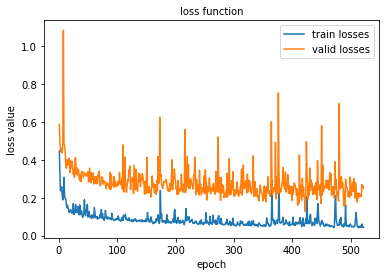

In [ ]:
loss_plot(stats_mpl["losses"])
metrics_evaluation_prediction(model_mpl, X_test, y_test["nbrMotInsulte"], to_tensor = True)

## Creation of a new toxicity index and classification

---

Now, changing the problem to classification, we will take as output the coding of the class `cluster_indexes` generated previously. Here we will evaluate basically three methodologies: support vector machine algorithm, best model xxxxxx and neuronal networks (again). Let's start with the support vector machine algorithm.

In [ ]:
''' Importan function to metrics evaluation '''
def metrics_evaluation_classification(model, X_test, y_test, to_tensor = False):
    if to_tensor:
        X_test = torch.from_numpy(X_test.values).float()
        X_test = X_test.to(device, dtype=torch.float32)
        with torch.no_grad():
            y_pred = model.forward(X_test)
        
        y_pred = y_pred.to("cpu").numpy()
        
        # Softmax
        y_pred = np.exp(y_pred)
        y_pred /= 4*np.expand_dims(np.mean(y_pred, axis = 1), axis = 1)
        y_pred = np.argmax(y_pred, axis = 1)
    else:
        y_pred = model.predict(X_test)
    
    print('Accuracy:', metrics.accuracy_score(y_test, y_pred))
    print('F1 score:', metrics.f1_score(y_test, y_pred, average='macro'))
    
    # Confusion matrix
    corr = metrics.confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(corr, cmap="RdYlBu", annot=True, square=True, vmin=-0.8, vmax=corr.max() + 0.8, fmt="+.1f")
    plt.title("Correlations between predictors")
    plt.show()

### Neuronal network for classification problem

As we changed the problem, it is necessary to redefine the chosen mini-batches, changing especially the output values. Now, the output will be the one-shot encoding of the `cluster_indexes` column.

In [ ]:
batch_size = 1024; batch_datasets = {}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_datasets["train"] = TensorDataset(torch.from_numpy(X_train.values).float(), torch.from_numpy(np.expand_dims(y_train["cluster_indexes"].values, axis = 1)).long())
batch_datasets["valid"] = TensorDataset(torch.from_numpy(X_valid.values).float(), torch.from_numpy(np.expand_dims(y_valid["cluster_indexes"].values, axis = 1)).long())

dataloaders = {x: DataLoader(batch_datasets[x], batch_size=batch_size, shuffle=True) for x in ['train', 'valid']}
dataset_sizes = {x: len(batch_datasets[x]) for x in ['train', 'valid']}
print(device, dataset_sizes)

cpu {'train': 33308, 'valid': 5878}


We will use the same procedure with the same parameters used before, unlike now we will consider one output per class and the cross entropy loss function.

In [ ]:
## Architecture definition
class MLP_NN(nn.Module):
    def __init__(self, neurons, p = False):
        super(MLP_NN, self).__init__()
        layers = []
        for i, n in enumerate(neurons[:-1]):
            layers += [nn.Linear(n, neurons[i + 1])]
            if i + 1 < len(neurons) - 1:     
                layers += [nn.ReLU(inplace = False)]
                if p is not None: layers += [nn.Dropout(p = p, inplace = False)]

        self.architecture = nn.Sequential(*layers)

    def forward(self, x):
        return self.architecture(x)

Let's start training!

In [ ]:
## Training definitions
experiments = 1
hidden_layers = [[X_train.shape[1]] + [x,y] + [4] for x in range(10,51,10) for y in range(10,51,10)]
drop_probas = [0.05, 0.1, 0.3, 0.5]
criterion = nn.CrossEntropyLoss()
save_stat = "stats_mpl_class.json" # For save statistics
model_name = "youtube_mpl_class.pt" # For save best model
''' os.remove(save_stat) # Delete previous results '''

# Complex process choose
model_mpl, stats_mpl = complex_train_procedure(experiments, hidden_layers, 
                            drop_probas, save_stat, model_name, MLP_NN, 
                            criterion, lr = 0.001, momentum = 0.9, 
                            step_size = 100, gamma = 0.9, num_epochs = 4000, 
                            early_max = 100, with_scheduler = False)

[INFO] The model has already been trained. Best all losses = 8.652795811843899e-05, with: do = 0.05, h = [12, 20, 30, 4].
[INFO] Time spent on experiment = 23m 9s.


The evaluation metrics for a classification problem changed. Therefore, the performance of our architecture is:

Accuracy: 0.9997108155002892
F1 score: 0.9997793822118028


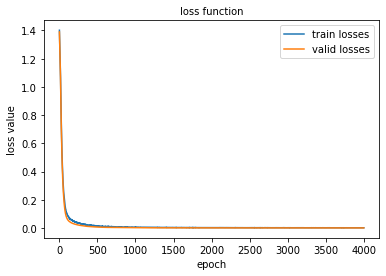

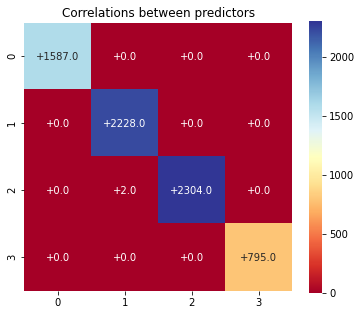

In [ ]:
loss_plot(stats_mpl["losses"])
metrics_evaluation_classification(model_mpl, X_test, y_test["cluster_indexes"], to_tensor = True)

In [ ]:
metrics.average_precision_score([1, 0, 1, 0], [0.2, 0.2, 0.2 ,0.2])

0.5

# **Conclusions**

<table>
<thead>
  <tr>
    <th>Regression Methods</th>
    <th>Mean&nbsp;&nbsp;&nbsp;Absolute Error</th>
    <th>Mean&nbsp;&nbsp;&nbsp;Squared Error</th>
    <th>Root&nbsp;&nbsp;&nbsp;Mean Squared Error</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>Gradient&nbsp;&nbsp;&nbsp;Boosting</td>
    <td>1,8562</td>
    <td>130,7360674</td>
    <td>11,43398738</td>
  </tr>
  <tr>
    <td>XGBoost</td>
    <td>2,702017816</td>
    <td>63,7850933</td>
    <td>7,986557037</td>
  </tr>
  <tr>
    <td>Logistic&nbsp;&nbsp;&nbsp;Regression</td>
    <td>4</td>
    <td>245,865799</td>
    <td>15,68010839</td>
  </tr>
  <tr>
    <td>KNN</td>
    <td>0,092611762</td>
    <td>1,029886974</td>
    <td>1,014833471</td>
  </tr>
  <tr>
    <td>Decision&nbsp;&nbsp;&nbsp;Tree</td>
    <td>0,061878184</td>
    <td>0,859721622</td>
    <td>0,927211746</td>
  </tr>
  <tr>
    <td>Random&nbsp;&nbsp;&nbsp;Forest</td>
    <td>0,026892091</td>
    <td>0,738542162</td>
    <td>0,859384758</td>
  </tr>
  <tr>
    <td>Suport&nbsp;&nbsp;&nbsp;Vector Regression (SVR)</td>
    <td>0,097340343</td>
    <td>0,130835106</td>
    <td>0,361711357</td>
  </tr>
  <tr>
    <td>Neuronal&nbsp;&nbsp;&nbsp;Networks (MLP)</td>
    <td>0,051045139</td>
    <td>0,051348232</td>
    <td>0,226601484</td>
  </tr>
</tbody>
</table>

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-fymr{border-color:inherit;font-weight:bold;text-align:left;vertical-align:top}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-fymr"><span style="font-weight:bold;color:#000">Classification Methods</span></th>
    <th class="tg-fymr"><span style="font-weight:bold;color:#000">Accuracy</span></th>
    <th class="tg-fymr"><span style="font-weight:bold;color:#000">F1 score</span></th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-0pky"><span style="font-weight:bold;color:#000">Gradient Boosting</span></td>
    <td class="tg-0pky"><span style="font-weight:normal;color:#000">1</span></td>
    <td class="tg-0pky"><span style="font-weight:normal;color:#000">1</span></td>
  </tr>
  <tr>
    <td class="tg-0pky"><span style="font-weight:bold;color:#000">XGBoost</span></td>
    <td class="tg-0pky"><span style="font-weight:normal;color:#000">1</span></td>
    <td class="tg-0pky"><span style="font-weight:normal;color:#000">1</span></td>
  </tr>
  <tr>
    <td class="tg-0pky"><span style="font-weight:bold;color:#000">Logistic Regression</span></td>
    <td class="tg-0pky"><span style="font-weight:normal;color:#000">1</span></td>
    <td class="tg-0pky"><span style="font-weight:normal;color:#000">1</span></td>
  </tr>
  <tr>
    <td class="tg-0pky"><span style="font-weight:bold;color:#000">KNN</span></td>
    <td class="tg-0pky"><span style="font-weight:normal;color:#000">0,9908893709</span></td>
    <td class="tg-0pky"><span style="font-weight:normal;color:#000">0,9911142904</span></td>
  </tr>
  <tr>
    <td class="tg-0pky"><span style="font-weight:bold;color:#000">Decision Tree</span></td>
    <td class="tg-0pky"><span style="font-weight:normal;color:#000">1</span></td>
    <td class="tg-0pky"><span style="font-weight:normal;color:#000">1</span></td>
  </tr>
  <tr>
    <td class="tg-0pky"><span style="font-weight:bold;color:#000">Random Forest</span></td>
    <td class="tg-0pky"><span style="font-weight:normal;color:#000">1</span></td>
    <td class="tg-0pky"><span style="font-weight:normal;color:#000">1</span></td>
  </tr>
  <tr>
    <td class="tg-0pky"><span style="font-weight:bold;color:#000">Neuronal Networks (MLP)</span></td>
    <td class="tg-0pky"><span style="font-weight:normal;color:#000">0,9997108155</span></td>
    <td class="tg-0pky"><span style="font-weight:normal;color:#000">0,9997793822</span></td>
  </tr>
</tbody>
</table>

1.   To perform a complete analysis on all prediction algorithms were taken into account three specific metrics with which we could compare the performance of each algorithm, these were Mean Absolute Error, Mean Squared Error and Root Mean Squared Error, it was observed that the algorithm that had a better performance in the application of the column 'nbr_insults' was the algorithm of Neuronal Networks (MLP) and was the algorithm that had less value in the metrics globally. However, it can be seen that the random forest, regression tree and support vector regression (SVR) algorithms had a fairly acceptable performance in all three metrics.

2.   We can conclude that the mean shift cluster indexes are a measure of toxicity. The toxicity is high for clusters 0 ans 1, medium for the cluster 2 and low for the cluster 3.

3.   To compare the performance of the sorters, the F1 Precision and Score metrics were calculated. For accuracy we have that if the complete set of labels predicted for a sample strictly matches the true set of labels, then the accuracy of the subset is 1.0; otherwise it is 0.0. On the other hand, for the F1-score we have that can be interpreted as a weighted average of the accuracy and recovery. For all the algorithms we have a good performance in general, therefore we base the choice of the best one by low complexity and execution time. In this case, we take the one of  Decision Tree.